Esta primera celda carga todas las herramientas y librerías que necesitaremos para el proyecto. Esto incluye PyTorch (para la red neuronal), Torchvision (para las imágenes), NumPy (para cálculos), Matplotlib/Seaborn (para gráficos) y Scikit-learn (para las métricas de evaluación).

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    classification_report,
)
import os
import sys
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import datetime

Aquí definimos todas las constantes y variables clave.

In [2]:
CARPETA_DATOS_AGRUPADOS = './dataset_agrupad_o'
DIRECTORIO_DATOS = CARPETA_DATOS_AGRUPADOS
DIRECTORIO_KAGGLE = "/kaggle/input"

print(f"Buscando el directorio 'preprocessed_data' con subcarpetas 'biome_' dentro de {DIRECTORIO_KAGGLE}...")

DIRECTORIO_ENTRADA_BIOMAS = None
try:
    for ruta_actual, carpetas, archivos in os.walk(DIRECTORIO_KAGGLE, topdown=True):
        if os.path.basename(ruta_actual) == 'preprocessed_data':
            if any(carpeta.startswith('biome_') for carpeta in carpetas):
                DIRECTORIO_ENTRADA_BIOMAS = ruta_actual
                print(f"Directorio de biomas válido encontrado en: {DIRECTORIO_ENTRADA_BIOMAS}")
                print(f"Subdirectorios de biomas detectados (muestra): {carpetas[:5]}")
                break
    if DIRECTORIO_ENTRADA_BIOMAS is None:
        print("--- ERROR FATAL (DETECCIÓN) ---")
        print("No se pudo encontrar un directorio 'preprocessed_data' válido que contenga subcarpetas 'biome_X'.")
        DIRECTORIO_ENTRADA_BIOMAS = "/kaggle/input/DIRECTORIO_NO_ENCONTRADO"
except Exception as e:
    print(f"Error fatal al buscar directorios: {e}")
    DIRECTORIO_ENTRADA_BIOMAS = "/kaggle/input/DIRECTORIO_NO_ENCONTRADO"

#Aqui estan definidas estas constantes en funcion de como se presentan las imagenes del dataset 
ALTO_IMAGEN = 180
ANCHO_IMAGEN = 320
TAMANO_LOTE = 32
PROPORCION_VALIDACION = 1 / 3
SEMILLA_ALEATORIA = 123
UMBRAL_MINORIA = 1000

# Este es el mapa de las agrupaciones definidas en el anteproyecto
MAPA_AGRUPACION_BIOMAS = {
    "Taiga": ["biome_5", "biome_19", "biome_32", "biome_33", "biome_133"],
    "Taiga Nevada": ["biome_30", "biome_31", "biome_158"],
    "Savana": ["biome_35", "biome_36"],
    "Jungla": ["biome_21", "biome_22"],
    "Bosque de Roble Oscuro": ["biome_29", "biome_157"],
    "Desierto": ["biome_2", "biome_17", "biome_130"],
    "Badlands": ["biome_37", "biome_38", "biome_39"],
    "Bosque de Abeto": ["biome_27", "biome_28", "biome_156"],
    "Pantano": ["biome_6"],
    "Bosque de Roble": ["biome_4", "biome_132"],
    "Planicies": ["biome_1", "biome_129"],
    "Bosque Mixto": ["biome_18", "biome_34"],
    "Tundra Nevada": ["biome_12"],
    "Montañas": ["biome_3", "biome_131", "biome_162"],
    "Montaña Nevada": ["biome_13"],
    "Playa": ["biome_16", "biome_26"],
    "Ríos": ["biome_7", "biome_11"]
}

BIOMAS_IGNORADOS = ["biome_10", "biome_45"]

Buscando el directorio 'preprocessed_data' con subcarpetas 'biome_' dentro de /kaggle/input...
Directorio de biomas válido encontrado en: /kaggle/input/minecraft-biomes/preprocessed_data
Subdirectorios de biomas detectados (muestra): ['biome_7', 'biome_12', 'biome_37', 'biome_162', 'biome_158']


Esta celda define la función preparar_y_agrupar_biomas

In [3]:
def preparar_y_agrupar_biomas():
    print(f"Directorio base de entrada detectado: {DIRECTORIO_ENTRADA_BIOMAS}")
    if not DIRECTORIO_ENTRADA_BIOMAS or not os.path.exists(DIRECTORIO_ENTRADA_BIOMAS) or not os.listdir(DIRECTORIO_ENTRADA_BIOMAS):
        print(f"--- ERROR FATAL ---\nEl directorio '{DIRECTORIO_ENTRADA_BIOMAS}' no existe o está vacío.")
        return False

    os.makedirs(CARPETA_DATOS_AGRUPADOS, exist_ok=True)
    print(f"El dataset agrupado se guardará en: {CARPETA_DATOS_AGRUPADOS}")

    try:
        nombres_biomas_originales = next(os.walk(DIRECTORIO_ENTRADA_BIOMAS))[1]
    except (StopIteration, FileNotFoundError) as e:
        print(f"Error: No se encontró una estructura de directorios válida en {DIRECTORIO_ENTRADA_BIOMAS}. {e}")
        return False

    mapa_inverso_biomas = {}
    for nueva_categoria, lista_biomas_antiguos in MAPA_AGRUPACION_BIOMAS.items():
        for bioma_antiguo_id in lista_biomas_antiguos:
            mapa_inverso_biomas[bioma_antiguo_id] = nueva_categoria

    print("Creando directorios de salida para las categorías agrupadas...")
    todas_las_categorias = list(MAPA_AGRUPACION_BIOMAS.keys())
    for nueva_categoria in todas_las_categorias:
        os.makedirs(os.path.join(CARPETA_DATOS_AGRUPADOS, nueva_categoria), exist_ok=True)

    biomas_originales_mapeados = set()
    nombre_carpeta_raiz = os.path.basename(DIRECTORIO_ENTRADA_BIOMAS)

    print(f"Recorriendo {DIRECTORIO_ENTRADA_BIOMAS} en busca de imágenes...")
    for ruta_actual, _, archivos in tqdm(os.walk(DIRECTORIO_ENTRADA_BIOMAS), desc="Procesando biomas"):
        bioma_actual_id = os.path.basename(ruta_actual)

        if bioma_actual_id == nombre_carpeta_raiz or bioma_actual_id in BIOMAS_IGNORADOS:
            continue

        if bioma_actual_id in mapa_inverso_biomas:
            biomas_originales_mapeados.add(bioma_actual_id)
            nueva_categoria = mapa_inverso_biomas[bioma_actual_id]
            directorio_nueva_categoria = os.path.join(CARPETA_DATOS_AGRUPADOS, nueva_categoria)

            for nombre_imagen in archivos:
                if not nombre_imagen.lower().endswith(('.jpg')):
                    continue

                ruta_origen = os.path.join(ruta_actual, nombre_imagen)
                nombre_destino = f"{bioma_actual_id}_{nombre_imagen}"
                ruta_destino = os.path.join(directorio_nueva_categoria, nombre_destino)

                if os.path.exists(ruta_destino):
                    continue

                try:
                    os.symlink(ruta_origen, ruta_destino)
                except (OSError, NotImplementedError, AttributeError):
                    import shutil
                    shutil.copy2(ruta_origen, ruta_destino)

    print("\n--- Proceso de agrupación completado ---")
    print("\n--- Verificación de Conteo (Desde carpetas de destino) ---")
    conteo_final_categorias = {}
    total_imagenes_agrupadas = 0

    for categoria in todas_las_categorias:
        ruta_categoria = os.path.join(CARPETA_DATOS_AGRUPADOS, categoria)
        try:
            archivos_en_categoria = os.listdir(ruta_categoria)
            conteo = len([f for f in archivos_en_categoria if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))])
        except FileNotFoundError:
            conteo = 0
        conteo_final_categorias[categoria] = conteo
    
    total_imagenes_agrupadas = sum(conteo_final_categorias.values())
    print(f"Total de imágenes encontradas en las carpetas de destino: {total_imagenes_agrupadas}")

    if total_imagenes_agrupadas == 0:
        print("0 imagenes procesadas. ¡Algo salió mal!")
    else:
        print("\nCantidad total de imagenes encontradas:")
        for categoria, conteo in conteo_final_categorias.items():
            print(f"- {categoria}: {conteo} imágenes")

    todos_biomas_originales_en_mapa = biomas_originales_mapeados | set(BIOMAS_IGNORADOS)
    biomas_sin_mapa = [b for b in nombres_biomas_originales if b not in todos_biomas_originales_en_mapa]

    if biomas_sin_mapa:
        print(f"\n¡Atención! Los siguientes directorios no fueron mapeados ni excluidos:")
        for b in biomas_sin_mapa: print(f"  - {b}")
    else:
        print("\n¡Perfecto! Todos los directorios fueron trabajados correctamente.")
    
    return True

Esta celda define cargar_y_preparar_datos

In [4]:
def cargar_y_preparar_datos(directorio_datos):
    if not os.path.exists(directorio_datos) or not os.listdir(directorio_datos):
        print(f"Error: El directorio '{directorio_datos}' está vacío o no existe.")
        return None, None, None, None, 0

    transformaciones_entrenamiento = transforms.Compose([
        transforms.Resize((ALTO_IMAGEN, ANCHO_IMAGEN)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.RandomResizedCrop((ALTO_IMAGEN, ANCHO_IMAGEN), scale=(0.9, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    transformaciones_validacion = transforms.Compose([
        transforms.Resize((ALTO_IMAGEN, ANCHO_IMAGEN)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    print("  -> Escaneando directorio de datos (ImageFolder)...")
    try:
        dataset_completo = datasets.ImageFolder(directorio_datos)
    except Exception as e:
        print(f"Error al cargar datos con ImageFolder desde '{directorio_datos}': {e}")
        return None, None, None, None, 0

    print(f"  -> Escaneo completo. {len(dataset_completo)} imágenes encontradas.")
    nombres_clases = dataset_completo.classes
    numero_de_clases = len(nombres_clases)
    print(f"Clases detectadas ({numero_de_clases}): {nombres_clases}")

    indices = list(range(len(dataset_completo)))
    corte = int(np.floor(PROPORCION_VALIDACION * len(dataset_completo)))

    np.random.seed(SEMILLA_ALEATORIA)
    np.random.shuffle(indices)

    indices_entrenamiento, indices_validacion = indices[corte:], indices[:corte]

    class DatasetPersonalizado(Dataset):
        def __init__(self, subset, transformacion):
            self.subset = subset
            self.transformacion = transformacion
        def __getitem__(self, index):
            imagen, etiqueta = self.subset[index]
            imagen = self.transformacion(imagen)
            return imagen, etiqueta
        def __len__(self):
            return len(self.subset)

    datos_entrenamiento = DatasetPersonalizado(
        torch.utils.data.Subset(dataset_completo, indices_entrenamiento),
        transformacion=transformaciones_entrenamiento
    )
    datos_validacion = DatasetPersonalizado(
        torch.utils.data.Subset(dataset_completo, indices_validacion),
        transformacion=transformaciones_validacion
    )

    print("  -> Calculando pesos para el muestreador (sampler)...")
    etiquetas_entrenamiento = []
    for i in tqdm(indices_entrenamiento, desc="   - Recopilando etiquetas (targets)"):
        etiquetas_entrenamiento.append(dataset_completo.targets[i])

    conteo_por_clase = np.bincount(etiquetas_entrenamiento, minlength=numero_de_clases)

    for i, nombre_clase in enumerate(nombres_clases):
        conteo = conteo_por_clase[i]
        if conteo < UMBRAL_MINORIA and conteo > 0:
            print(f"  -> (Sobremuestreo): {nombre_clase} (índice {i}) con {conteo} imágenes.")
        else:
            print(f"  -> (Normal): {nombre_clase} (índice {i}) con {conteo} imágenes.")

    conteo_por_clase[conteo_por_clase == 0] = 1
    pesos_por_clase = 1. / conteo_por_clase

    lista_pesos_muestras = []
    for t in tqdm(etiquetas_entrenamiento, desc="   - Calculando pesos (weights)"):
        lista_pesos_muestras.append(pesos_por_clase[t])
    pesos_muestras_tensor = torch.from_numpy(np.array(lista_pesos_muestras)).double()

    print("  -> Creando DataLoader de Validación...")
    cargador_validacion = DataLoader(datos_validacion,
                                   batch_size=TAMANO_LOTE,
                                   shuffle=False,
                                   num_workers=2,
                                   pin_memory=True)

    print(f"\nDatasets listos. Entreno: {len(datos_entrenamiento)}, Prueba: {len(datos_validacion)}")
    return datos_entrenamiento, pesos_muestras_tensor, cargador_validacion, nombres_clases, numero_de_clases

Esta celda define la arquitectura de nuestra Red Neuronal Convolucional (CNN) usando una clase de PyTorch.

In [5]:
class ClasificadorBiomasCNN(nn.Module):
    def __init__(self, numero_de_clases, tipo_arquitectura="estandar"):
        super(ClasificadorBiomasCNN, self).__init__()
        self.tipo_arquitectura = tipo_arquitectura

        capas_convolucionales = []
        if tipo_arquitectura == "estandar":
            capas_convolucionales.append(nn.Conv2d(3, 32, kernel_size=3, padding=1))
            capas_convolucionales.append(nn.ReLU())
            capas_convolucionales.append(nn.MaxPool2d(kernel_size=2, stride=2))
            capas_convolucionales.append(nn.Conv2d(32, 64, kernel_size=3, padding=1))
            capas_convolucionales.append(nn.ReLU())
            capas_convolucionales.append(nn.MaxPool2d(kernel_size=2, stride=2))
            capas_convolucionales.append(nn.Conv2d(64, 128, kernel_size=3, padding=1))
            capas_convolucionales.append(nn.ReLU())
            capas_convolucionales.append(nn.MaxPool2d(kernel_size=2, stride=2))
            capas_convolucionales.append(nn.Conv2d(128, 256, kernel_size=3, padding=1))
            capas_convolucionales.append(nn.ReLU())
            capas_convolucionales.append(nn.MaxPool2d(kernel_size=2, stride=2))
            self.tamano_vector_aplanado = 256 * 11 * 20

        elif tipo_arquitectura == "simple":
            capas_convolucionales.append(nn.Conv2d(3, 32, kernel_size=3, padding=1))
            capas_convolucionales.append(nn.ReLU())
            capas_convolucionales.append(nn.MaxPool2d(kernel_size=2, stride=2))
            capas_convolucionales.append(nn.Conv2d(32, 64, kernel_size=3, padding=1))
            capas_convolucionales.append(nn.ReLU())
            capas_convolucionales.append(nn.MaxPool2d(kernel_size=2, stride=2))
            self.tamano_vector_aplanado = 64 * 45 * 80

        else:
            raise ValueError("Tipo de arquitectura no reconocido. Use 'estandar' o 'simple'.")

        self.extractor_caracteristicas = nn.Sequential(*capas_convolucionales)

        capas_clasificacion = []
        if tipo_arquitectura == "estandar":
            capas_clasificacion.append(nn.Linear(self.tamano_vector_aplanado, 1024))
            capas_clasificacion.append(nn.ReLU())
            capas_clasificacion.append(nn.Dropout(0.5))
            capas_clasificacion.append(nn.Linear(1024, 512))
            capas_clasificacion.append(nn.ReLU())
            capas_clasificacion.append(nn.Dropout(0.4))
            capas_clasificacion.append(nn.Linear(512, 256))
            capas_clasificacion.append(nn.ReLU())
            capas_clasificacion.append(nn.Dropout(0.3))
            capas_clasificacion.append(nn.Linear(256, 128))
            capas_clasificacion.append(nn.ReLU())
            capas_clasificacion.append(nn.Dropout(0.2))
            capas_clasificacion.append(nn.Linear(128, 64))
            capas_clasificacion.append(nn.ReLU())
            capas_clasificacion.append(nn.Dropout(0.1))
            capas_clasificacion.append(nn.Linear(64, numero_de_clases))

        elif tipo_arquitectura == "simple":
            capas_clasificacion.append(nn.Linear(self.tamano_vector_aplanado, 128))
            capas_clasificacion.append(nn.ReLU())
            capas_clasificacion.append(nn.Dropout(0.5))
            capas_clasificacion.append(nn.Linear(128, numero_de_clases))
        self.clasificador_final = nn.Sequential(*capas_clasificacion)

    def forward(self, imagen):
        caracteristicas = self.extractor_caracteristicas(imagen)
        vector_plano = torch.flatten(caracteristicas, 1)
        puntuaciones = self.clasificador_final(vector_plano)
        return puntuaciones

Esta celda contiene las funciones que gestionan el ciclo de vida del modelo.

In [6]:
def entrenar_modelo(red_neuronal, cargador_entrenamiento, numero_epocas, tasa_aprendizaje, dispositivo):
    funcion_de_perdida = nn.CrossEntropyLoss()
    optimizador = optim.Adam(red_neuronal.parameters(), lr=tasa_aprendizaje)
    historial_perdida = []
    red_neuronal.to(dispositivo)

    for epoca in range(numero_epocas):
        perdida_acumulada = 0.0   
        red_neuronal.train()
        barra_progreso = tqdm(cargador_entrenamiento, desc=f"Época {epoca+1}/{numero_epocas}", unit="batch")

        for imagenes, etiquetas in barra_progreso:
            imagenes, etiquetas = imagenes.to(dispositivo), etiquetas.to(dispositivo)
            optimizador.zero_grad()
            salidas = red_neuronal(imagenes)
            perdida = funcion_de_perdida(salidas, etiquetas)
            perdida.backward()
            optimizador.step()
            perdida_acumulada += perdida.item()
            barra_progreso.set_postfix(loss=perdida.item())
        perdida_promedio_epoca = perdida_acumulada / len(cargador_entrenamiento)
        historial_perdida.append(perdida_promedio_epoca)
        print(f"Época {epoca+1}/{numero_epocas} completada. Loss Promedio: {perdida_promedio_epoca:.4f}")
    print("Entrenamiento finalizado.")
    return historial_perdida

def graficar_historial_perdida(historial_perdida):
    plt.figure()
    plt.plot(historial_perdida, label='Pérdida (Loss) de Entrenamiento')
    plt.title("Historial de Pérdida (Loss) por Época")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

def evaluar_modelo(red_neuronal, cargador_pruebas, dispositivo, nombres_clases):
    red_neuronal.to(dispositivo)
    red_neuronal.eval()
    todas_predicciones = []
    todas_etiquetas_reales = []
    print("Evaluando modelo contra el conjunto de prueba...")
    barra_progreso = tqdm(cargador_pruebas, desc="Evaluando", unit="batch")
    with torch.no_grad():
        for imagenes, etiquetas in barra_progreso:
            imagenes, etiquetas = imagenes.to(dispositivo), etiquetas.to(dispositivo)
            salidas = red_neuronal(imagenes)
            _, prediccion = torch.max(salidas.data, 1)         
            todas_predicciones.extend(prediccion.cpu().numpy())
            todas_etiquetas_reales.extend(etiquetas.cpu().numpy())
    accuracy = accuracy_score(todas_etiquetas_reales, todas_predicciones)
    precision = precision_score(todas_etiquetas_reales, todas_predicciones, average='macro', zero_division=0)
    recall = recall_score(todas_etiquetas_reales, todas_predicciones, average='macro', zero_division=0)

    print("\n" + "="*60)
    print("          RESULTADOS DE LA EVALUACIÓN (BIOMAS)")
    print("="*60)
    print(f"Accuracy (Exactitud): {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision (Precisión - Macro): {precision:.4f} ({precision*100:.2f}%)")
    print(f"Recall (Sensibilidad - Macro): {recall:.4f} ({recall*100:.2f}%)")
    print("="*60)
    print("\n--- Reporte de Clasificación (Precisión, Recall, F1) ---")
    print(classification_report(todas_etiquetas_reales, todas_predicciones, target_names=nombres_clases, zero_division=0))
    print("Generando Matriz de Confusión...")
    matriz_confusion = confusion_matrix(todas_etiquetas_reales, todas_predicciones)
    plt.figure(figsize=(14, 12))
    ax = sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues',
                xticklabels=nombres_clases, yticklabels=nombres_clases, annot_kws={"size": 10})
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_xlabel("Bioma Predicho", fontsize=12)
    ax.set_ylabel("Bioma Real", fontsize=12)
    ax.set_title("Matriz de Confusión - Biomas", fontsize=14, weight="bold")
    plt.tight_layout()
    plt.show()
    print("Gráfico de Matriz de Confusión generado.")

Esta celda define funciones de ayuda para gestionar el modelo y probarlo.

In [7]:
def guardar_red_neuronal(red_neuronal, parametros_arquitectura, nombre_archivo):
    estado_modelo = {
        'state_dict': red_neuronal.to('cpu').state_dict(),
        'arch_params': parametros_arquitectura
    }
    ruta_guardado = os.path.basename(nombre_archivo)
    if not ruta_guardado:
        ruta_guardado = "mi_modelo.pth"     
    torch.save(estado_modelo, ruta_guardado)
    print(f"Modelo guardado en {os.path.abspath(ruta_guardado)}")

def cargar_red_neuronal(nombre_archivo, dispositivo):
    if not os.path.exists(nombre_archivo):
        print(f"Error: El archivo '{nombre_archivo}' no existe.")
        return None, None       
    try:
        estado_cargado = torch.load(nombre_archivo, map_location=dispositivo)
    except Exception as e:
        print(f"Error al leer el archivo. ¿Es un archivo .pth válido? ({e})")
        return None, None
    if 'arch_params' not in estado_cargado or 'state_dict' not in estado_cargado:
        print("Error: El archivo .pth no contiene 'arch_params' o 'state_dict'.")
        return None, None
    parametros_arquitectura = estado_cargado['arch_params']
    if 'num_classes' not in parametros_arquitectura and 'numero_de_clases' in parametros_arquitectura:
        parametros_arquitectura['num_classes'] = parametros_arquitectura.pop('numero_de_clases')
    if 'architecture_type' not in parametros_arquitectura and 'tipo_arquitectura' in parametros_arquitectura:
        parametros_arquitectura['architecture_type'] = parametros_arquitectura.pop('tipo_arquitectura')
    params_creacion = {
        'numero_de_clases': parametros_arquitectura['num_classes'],
        'tipo_arquitectura': parametros_arquitectura.get('architecture_type', 'estandar') # default
    }
    red_neuronal = ClasificadorBiomasCNN(**params_creacion) 
    red_neuronal.load_state_dict(estado_cargado['state_dict'])
    red_neuronal.to(dispositivo)
    print(f"Modelo cargado desde {nombre_archivo} al dispositivo {dispositivo}")
    print("\n--- Configuración de la Red Cargada ---")
    print(f"Tipo: {params_creacion['tipo_arquitectura']}")
    print(f"Salida (Clases): {params_creacion['numero_de_clases']}")
    print(red_neuronal)
    print("--------------------------------------")
    return red_neuronal, parametros_arquitectura

def buscar_imagenes_para_predecir(directorio_busqueda, directorio_a_excluir):
    rutas_imagenes_encontradas = []
    print(f"Buscando imágenes de prueba en: {directorio_busqueda}")
    excluir_dataset_dir = ""
    if directorio_a_excluir and os.path.exists(directorio_a_excluir):
        excluir_dataset_dir = os.path.abspath(directorio_a_excluir)
        print(f"Excluyendo directorio de dataset: {excluir_dataset_dir}")      
    excluir_output_dir = os.path.abspath(CARPETA_DATOS_AGRUPADOS)
    print(f"Excluyendo directorio de salida: {excluir_output_dir}")
    for ruta_actual, _, archivos in os.walk(directorio_busqueda, topdown=True):
        ruta_absoluta = os.path.abspath(ruta_actual) 
        if excluir_dataset_dir and ruta_absoluta.startswith(excluir_dataset_dir):
            continue
        if ruta_absoluta.startswith(excluir_output_dir):
            continue
        for nombre_archivo in archivos:
            if nombre_archivo.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                ruta_completa = os.path.join(ruta_actual, nombre_archivo)
                rutas_imagenes_encontradas.append(ruta_completa)
                
    return rutas_imagenes_encontradas

def predecir_imagen_individual(red_neuronal, nombres_clases, dispositivo):
    print("\n--- Predecir Imagen Individual (Desde Lista) ---")
    imagenes_encontradas = buscar_imagenes_para_predecir(DIRECTORIO_KAGGLE, DIRECTORIO_ENTRADA_BIOMAS)
    
    if not imagenes_encontradas:
        print(f"No se encontraron imágenes de prueba (jpg, png) en '{DIRECTORIO_KAGGLE}'")
        print(f"(Asegúrese de que NO estén dentro de '{DIRECTORIO_ENTRADA_BIOMAS}')")
        print("Por favor, añada un dataset que contenga imágenes de prueba (ej. 'test-images').")
        return

    print("Imágenes de prueba encontradas:")
    for i, ruta_img in enumerate(imagenes_encontradas):
        ruta_mostrada = ruta_img.replace(DIRECTORIO_KAGGLE, '.../input')
        print(f"  {i + 1}: {ruta_mostrada}")

    ruta_elegida = None
    while ruta_elegida is None:
        try:
            opcion_str = input(f"Seleccione el número de la imagen (1-{len(imagenes_encontradas)}): ")
            opcion_int = int(opcion_str) - 1
            if 0 <= opcion_int < len(imagenes_encontradas):
                ruta_elegida = imagenes_encontradas[opcion_int]
            else:
                print("Número fuera de rango. Intente de nuevo.")
        except ValueError:
            print("Entrada no válida. Por favor, ingrese un número.")

    print(f"Cargando imagen seleccionada: {ruta_elegida}")
    try:
        transformaciones_prediccion = transforms.Compose([
            transforms.Resize((ALTO_IMAGEN, ANCHO_IMAGEN)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        imagen = Image.open(ruta_elegida).convert("RGB")
        imagen_tensor = transformaciones_prediccion(imagen)
        imagen_lote = imagen_tensor.unsqueeze(0)
        red_neuronal.to(dispositivo)
        red_neuronal.eval()

        with torch.no_grad():
            salidas = red_neuronal(imagen_lote.to(dispositivo))
            probabilidades = torch.nn.functional.softmax(salidas, dim=1)
            puntuaciones = probabilidades[0]
            confianza, indice_predicho = torch.max(puntuaciones, 0)

        clase_predicha = nombres_clases[indice_predicho.item()]

        print("\n--- Resultado ---")
        print(f"Archivo: {os.path.basename(ruta_elegida)}")
        print(f"La red cree que es: {clase_predicha}")
        print(f"Confianza: {confianza.item() * 100:.2f}%")

    except Exception as e:
        print(f"Error al procesar la imagen: {e}")

Esta celda define la interfaz de usuario que nos permite interactuar con el modelo cuando corre en draft

In [8]:
def menu_interactivo_modelo(red_neuronal, parametros_arquitectura, datos_entrenamiento, pesos_muestras_tensor, cargador_validacion, nombres_clases, dispositivo):
    historial_perdida = []
    
    while True:
        print("\n--- Menú de Red - Clasificador de Biomas ---")
        print(f"Modelo en memoria: {parametros_arquitectura.get('architecture_type', 'N/A')}")
        print("1. Entrenar la red")
        print("2. Probar (Evaluar) la red")
        print("3. Predecir imagen individual")
        print("4. Guardar la red")
        print("5. Volver al menú principal")
        opcion = input("Seleccione una opción: ")

        if opcion == '1':
            try:
                epocas = int(input("Ingrese el número de épocas (ej. 10): ") or 10)
                lr = float(input("Ingrese la tasa de aprendizaje (ej. 0.001): ") or 0.001)
                porcentaje_str = input("Porcentaje del dataset de entrenamiento a usar (1-100) [Default: 100]: ") or "100"
                porcentaje = float(porcentaje_str) / 100.0
                
                if not (0.01 <= porcentaje <= 1.0):
                    print("Porcentaje inválido. Usando 100%.")
                    porcentaje = 1.0
                    
                total_muestras_entrenamiento = len(pesos_muestras_tensor)
                
                if porcentaje < 1.0:
                    muestras_a_usar = int(total_muestras_entrenamiento * porcentaje)
                    print(f"Usando {porcentaje*100:.0f}% del dataset. {muestras_a_usar} muestras por época.")
                else:
                    muestras_a_usar = total_muestras_entrenamiento
                    print(f"Usando 100% del dataset. {muestras_a_usar} muestras por época.")

                muestreador_entrenamiento = torch.utils.data.WeightedRandomSampler(
                    weights=pesos_muestras_tensor,
                    num_samples=muestras_a_usar,
                    replacement=True
                )
                
                cargador_entrenamiento_actual = DataLoader(datos_entrenamiento,
                                                          batch_size=TAMANO_LOTE,
                                                          sampler=muestreador_entrenamiento,
                                                          num_workers=2,
                                                          pin_memory=True)

                print(f"Entrenando por {epocas} épocas con LR={lr} en {dispositivo}...")
                nueva_perdida = entrenar_modelo(red_neuronal, cargador_entrenamiento_actual, epocas, lr, dispositivo)
                historial_perdida.extend(nueva_perdida)
                graficar_historial_perdida(historial_perdida)

            except ValueError:
                print("Error: Entrada no válida.")
        
        elif opcion == '2':
            print(f"Probando modelo contra el conjunto de prueba en {dispositivo}...")
            evaluar_modelo(red_neuronal, cargador_validacion, dispositivo, nombres_clases)
        
        elif opcion == '3':
            predecir_imagen_individual(red_neuronal, nombres_clases, dispositivo)
        
        elif opcion == '4':
            nombre_archivo = input("Ingrese el nombre para guardar el modelo (ej: mi_modelo.pth): ")
            if not nombre_archivo.endswith(".pth"):
                nombre_archivo += ".pth"
            if nombre_archivo:
                guardar_red_neuronal(red_neuronal, parametros_arquitectura, nombre_archivo)
            else:
                print("Guardado cancelado (nombre vacío).")
        
        elif opcion == '5':
            print("Volviendo al menú principal...")
            break
        
        else:
            print("Opción no válida. Intente de nuevo.")

def menu_principal():
    red_neuronal_activa = None
    params_arquitectura_activos = None
    dispositivo = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    while True:
        print("\n" + "="*50)
        print("  Panel de Control - Clasificador de Biomas (PyTorch)")
        print(f" (Usando dispositivo: {dispositivo})")
        print("="*50)
        print("1. Preparar datos y Crear nueva red (CNN)")
        print("2. Cargar una red desde archivo (.pth)")
        print("3. Salir")
        opcion_principal = input("Seleccione una opción: ")

        if opcion_principal == '1':
            try:
                print("\n--- FASE 1: Agrupando y verificando el dataset ---")
                if not preparar_y_agrupar_biomas():
                    print("Error crítico en la agrupación del dataset. Abortando.")
                    continue

                print("\n--- FASE 2: Cargando y preparando datasets (PyTorch) ---")
                datos_entrenamiento, pesos_muestras_tensor, cargador_validacion, nombres_clases, numero_de_clases = cargar_y_preparar_datos(DIRECTORIO_DATOS)
                
                if datos_entrenamiento is None:
                    print("No se pudieron cargar los datos. Volviendo al menú.")
                    continue
                print("\n--- FASE 3: Creación de Modelo (CNN) ---")
                opcion_arquitectura = input("¿Qué arquitectura desea? (1: Estándar, 2: Simple) [Default: 1]: ") or "1"
                tipo_arquitectura = "simple" if opcion_arquitectura == "2" else "estandar"
                params_arquitectura_activos = {
                    'num_classes': numero_de_clases,
                    'architecture_type': tipo_arquitectura
                }
                
                params_creacion_modelo = {
                    'numero_de_clases': params_arquitectura_activos['num_classes'],
                    'tipo_arquitectura': params_arquitectura_activos['architecture_type']
                }

                red_neuronal_activa = ClasificadorBiomasCNN(**params_creacion_modelo).to(dispositivo)
                print("\n--- Nueva Red CNN Creada ---")
                print(red_neuronal_activa)
                print("------------------------------")  
                menu_interactivo_modelo(red_neuronal_activa, params_arquitectura_activos, datos_entrenamiento, pesos_muestras_tensor, cargador_validacion, nombres_clases, dispositivo)

            except ValueError:
                print("Error: Entrada numérica no válida.")
            except Exception as e:
                print(f"Ocurrió un error creando la red: {e}")
                import traceback
                traceback.print_exc()

        elif opcion_principal == '2':
            print("\n--- Cargar Modelo ---")
            print("Buscando archivos .pth en el directorio actual y subdirectorios...")
            archivos_pth_encontrados = []
            for ruta_actual, _, archivos in os.walk('.'):
                for f in archivos:
                    if f.endswith(".pth"):
                        archivos_pth_encontrados.append(os.path.join(ruta_actual, f))
            
            if not archivos_pth_encontrados:
                print("No se encontraron archivos .pth.")
                print("Asegúrate de haber guardado un modelo previamente.")
                continue

            print("Archivos .pth encontrados:")
            for i, ruta_archivo in enumerate(archivos_pth_encontrados):
                print(f"  {i + 1}: {ruta_archivo}")
            nombre_archivo_cargado = None
            while nombre_archivo_cargado is None:
                try:
                    opcion_str = input(f"Seleccione el número del modelo a cargar (1-{len(archivos_pth_encontrados)}): ")
                    opcion_int = int(opcion_str) - 1
                    if 0 <= opcion_int < len(archivos_pth_encontrados):
                        nombre_archivo_cargado = archivos_pth_encontrados[opcion_int]
                    else:
                        print("Número fuera de rango.")
                except ValueError:
                    print("Entrada no válida.")
            
            print(f"Cargando modelo: {nombre_archivo_cargado}")
            try:
                red_neuronal_activa, params_arquitectura_activos = cargar_red_neuronal(nombre_archivo_cargado, dispositivo)
                
                if red_neuronal_activa and params_arquitectura_activos:
                    print("\n--- FASE 1: Verificando datos (necesarios para la red cargada) ---")
                    if not os.path.exists(DIRECTORIO_DATOS) or not os.listdir(DIRECTORIO_DATOS):
                        print("El directorio de datos agrupados no existe. Ejecutando agrupación...")
                        if not preparar_y_agrupar_biomas():
                            print("Error crítico en la agrupación del dataset. Abortando.")
                            continue
                    else:
                        print("Directorio de datos agrupados encontrado.")
                    print("\n--- FASE 2: Cargando y preparando datasets (PyTorch) ---")
                    datos_entrenamiento, pesos_muestras_tensor, cargador_validacion, nombres_clases, numero_de_clases = cargar_y_preparar_datos(DIRECTORIO_DATOS)           
                    if datos_entrenamiento is None:
                        print("No se pudieron cargar los datos para la red. Volviendo al menú.")
                        continue        
                    if numero_de_clases != params_arquitectura_activos['num_classes']:
                        print(f"¡ADVERTENCIA! El modelo fue entrenado con {params_arquitectura_activos['num_classes']} clases,")
                        print(f"pero los datos en '{DIRECTORIO_DATOS}' tienen {numero_de_clases} clases.")
                        print("Esto causará un error. Asegúrate de que los datos agrupados coincidan con el modelo.")
                        continue
                        
                    menu_interactivo_modelo(red_neuronal_activa, params_arquitectura_activos, datos_entrenamiento, pesos_muestras_tensor, cargador_validacion, nombres_clases, dispositivo)

            except FileNotFoundError:
                print(f"Error: El archivo '{nombre_archivo_cargado}' no fue encontrado.")
            except Exception as e:
                print(f"Ocurrió un error al cargar o probar la red: {e}")
                import traceback
                traceback.print_exc()

        elif opcion_principal == '3':
            print("Saliendo del programa.")
            break
        
        else:
            print("Opción no válida. Por favor, intente de nuevo.")

Punto de ejecucion del codigo donde se termina de definir

--- MODO NO INTERACTIVO (COMMIT / RUN ALL) ---
Iniciando flujo automático (sin inputs).

 (Usando dispositivo: cuda)

--- FASE 1: Agrupando y verificando el dataset ---
Directorio base de entrada detectado: /kaggle/input/minecraft-biomes/preprocessed_data
El dataset agrupado se guardará en: ./dataset_agrupad_o
Creando directorios de salida para las categorías agrupadas...
Recorriendo /kaggle/input/minecraft-biomes/preprocessed_data en busca de imágenes...


Procesando biomas: 42it [00:36,  1.17it/s]



--- Proceso de agrupación completado ---

--- Verificación de Conteo (Desde carpetas de destino) ---
Total de imágenes encontradas en las carpetas de destino: 22049

Cantidad total de imagenes encontradas:
- Taiga: 2346 imágenes
- Taiga Nevada: 420 imágenes
- Savana: 1164 imágenes
- Jungla: 444 imágenes
- Bosque de Roble Oscuro: 870 imágenes
- Desierto: 2088 imágenes
- Badlands: 210 imágenes
- Bosque de Abeto: 1122 imágenes
- Pantano: 665 imágenes
- Bosque de Roble: 2850 imágenes
- Planicies: 3186 imágenes
- Bosque Mixto: 1320 imágenes
- Tundra Nevada: 1254 imágenes
- Montañas: 2652 imágenes
- Montaña Nevada: 474 imágenes
- Playa: 540 imágenes
- Ríos: 444 imágenes

¡Perfecto! Todos los directorios fueron trabajados correctamente.

--- FASE 2: Cargando y preparando datasets (PyTorch) ---
  -> Escaneando directorio de datos (ImageFolder)...
  -> Escaneo completo. 22049 imágenes encontradas.
Clases detectadas (17): ['Badlands', 'Bosque Mixto', 'Bosque de Abeto', 'Bosque de Roble', 'Bosqu

   - Recopilando etiquetas (targets): 100%|██████████| 14700/14700 [00:00<00:00, 3289036.00it/s]


  -> (Sobremuestreo): Badlands (índice 0) con 146 imágenes.
  -> (Sobremuestreo): Bosque Mixto (índice 1) con 861 imágenes.
  -> (Sobremuestreo): Bosque de Abeto (índice 2) con 767 imágenes.
  -> (Normal): Bosque de Roble (índice 3) con 1920 imágenes.
  -> (Sobremuestreo): Bosque de Roble Oscuro (índice 4) con 568 imágenes.
  -> (Normal): Desierto (índice 5) con 1406 imágenes.
  -> (Sobremuestreo): Jungla (índice 6) con 305 imágenes.
  -> (Sobremuestreo): Montaña Nevada (índice 7) con 301 imágenes.
  -> (Normal): Montañas (índice 8) con 1783 imágenes.
  -> (Sobremuestreo): Pantano (índice 9) con 450 imágenes.
  -> (Normal): Planicies (índice 10) con 2122 imágenes.
  -> (Sobremuestreo): Playa (índice 11) con 356 imágenes.
  -> (Sobremuestreo): Ríos (índice 12) con 306 imágenes.
  -> (Sobremuestreo): Savana (índice 13) con 774 imágenes.
  -> (Normal): Taiga (índice 14) con 1534 imágenes.
  -> (Sobremuestreo): Taiga Nevada (índice 15) con 273 imágenes.
  -> (Sobremuestreo): Tundra Nevada 

   - Calculando pesos (weights): 100%|██████████| 14700/14700 [00:00<00:00, 3345611.20it/s]

  -> Creando DataLoader de Validación...

Datasets listos. Entreno: 14700, Prueba: 7349

--- FASE 3: Creación de Modelo (CNN) ---
Arquitectura seleccionada: estandar



--- Nueva Red CNN Creada ---

--- FASE 4: Iniciando Entrenamiento ---
Épocas: 400, LR: 0.001, Dataset: 100%


Época 1/400: 100%|██████████| 460/460 [01:05<00:00,  7.05batch/s, loss=1.59]


Época 1/400 completada. Loss Promedio: 2.1632


Época 2/400: 100%|██████████| 460/460 [00:57<00:00,  8.00batch/s, loss=0.944]


Época 2/400 completada. Loss Promedio: 1.5219


Época 3/400: 100%|██████████| 460/460 [01:01<00:00,  7.53batch/s, loss=1.81]


Época 3/400 completada. Loss Promedio: 1.3093


Época 4/400: 100%|██████████| 460/460 [00:55<00:00,  8.31batch/s, loss=0.573]


Época 4/400 completada. Loss Promedio: 1.1266


Época 5/400: 100%|██████████| 460/460 [00:57<00:00,  8.01batch/s, loss=0.406]


Época 5/400 completada. Loss Promedio: 1.0227


Época 6/400: 100%|██████████| 460/460 [00:59<00:00,  7.77batch/s, loss=1.54]


Época 6/400 completada. Loss Promedio: 1.0170


Época 7/400: 100%|██████████| 460/460 [00:53<00:00,  8.59batch/s, loss=1.42]


Época 7/400 completada. Loss Promedio: 0.9008


Época 8/400: 100%|██████████| 460/460 [00:55<00:00,  8.31batch/s, loss=0.691]


Época 8/400 completada. Loss Promedio: 0.8703


Época 9/400: 100%|██████████| 460/460 [00:53<00:00,  8.56batch/s, loss=0.819]


Época 9/400 completada. Loss Promedio: 0.8445


Época 10/400: 100%|██████████| 460/460 [00:55<00:00,  8.23batch/s, loss=0.359]


Época 10/400 completada. Loss Promedio: 0.7995


Época 11/400: 100%|██████████| 460/460 [00:53<00:00,  8.64batch/s, loss=0.811]


Época 11/400 completada. Loss Promedio: 0.7756


Época 12/400: 100%|██████████| 460/460 [00:56<00:00,  8.17batch/s, loss=1.02]


Época 12/400 completada. Loss Promedio: 0.7327


Época 13/400: 100%|██████████| 460/460 [00:54<00:00,  8.43batch/s, loss=0.505]


Época 13/400 completada. Loss Promedio: 0.7208


Época 14/400: 100%|██████████| 460/460 [00:52<00:00,  8.78batch/s, loss=0.507]


Época 14/400 completada. Loss Promedio: 0.6938


Época 15/400: 100%|██████████| 460/460 [00:55<00:00,  8.34batch/s, loss=0.346]


Época 15/400 completada. Loss Promedio: 0.6566


Época 16/400: 100%|██████████| 460/460 [00:52<00:00,  8.75batch/s, loss=0.387]


Época 16/400 completada. Loss Promedio: 0.6645


Época 17/400: 100%|██████████| 460/460 [00:56<00:00,  8.19batch/s, loss=0.46]


Época 17/400 completada. Loss Promedio: 0.6063


Época 18/400: 100%|██████████| 460/460 [00:55<00:00,  8.31batch/s, loss=0.287]


Época 18/400 completada. Loss Promedio: 0.5994


Época 19/400: 100%|██████████| 460/460 [00:51<00:00,  8.92batch/s, loss=0.443]


Época 19/400 completada. Loss Promedio: 0.5748


Época 20/400: 100%|██████████| 460/460 [00:56<00:00,  8.21batch/s, loss=0.399]


Época 20/400 completada. Loss Promedio: 0.6353


Época 21/400: 100%|██████████| 460/460 [00:51<00:00,  8.91batch/s, loss=0.666]


Época 21/400 completada. Loss Promedio: 0.5515


Época 22/400: 100%|██████████| 460/460 [00:53<00:00,  8.63batch/s, loss=0.193]


Época 22/400 completada. Loss Promedio: 0.5446


Época 23/400: 100%|██████████| 460/460 [00:52<00:00,  8.76batch/s, loss=0.623]


Época 23/400 completada. Loss Promedio: 0.5442


Época 24/400: 100%|██████████| 460/460 [00:52<00:00,  8.73batch/s, loss=0.599]


Época 24/400 completada. Loss Promedio: 0.5045


Época 25/400: 100%|██████████| 460/460 [00:53<00:00,  8.59batch/s, loss=0.636]


Época 25/400 completada. Loss Promedio: 0.4817


Época 26/400: 100%|██████████| 460/460 [00:54<00:00,  8.52batch/s, loss=0.38]


Época 26/400 completada. Loss Promedio: 0.4787


Época 27/400: 100%|██████████| 460/460 [00:51<00:00,  8.88batch/s, loss=0.0711]


Época 27/400 completada. Loss Promedio: 0.5126


Época 28/400: 100%|██████████| 460/460 [00:54<00:00,  8.43batch/s, loss=0.39]


Época 28/400 completada. Loss Promedio: 0.5100


Época 29/400: 100%|██████████| 460/460 [00:52<00:00,  8.77batch/s, loss=0.71]


Época 29/400 completada. Loss Promedio: 0.4602


Época 30/400: 100%|██████████| 460/460 [00:56<00:00,  8.07batch/s, loss=0.953]


Época 30/400 completada. Loss Promedio: 0.4354


Época 31/400: 100%|██████████| 460/460 [00:56<00:00,  8.19batch/s, loss=0.819]


Época 31/400 completada. Loss Promedio: 0.4556


Época 32/400: 100%|██████████| 460/460 [00:52<00:00,  8.82batch/s, loss=0.232]


Época 32/400 completada. Loss Promedio: 0.4207


Época 33/400: 100%|██████████| 460/460 [00:51<00:00,  8.90batch/s, loss=0.344]


Época 33/400 completada. Loss Promedio: 0.4705


Época 34/400: 100%|██████████| 460/460 [00:52<00:00,  8.71batch/s, loss=0.684]


Época 34/400 completada. Loss Promedio: 0.4279


Época 35/400: 100%|██████████| 460/460 [00:51<00:00,  8.98batch/s, loss=0.144]


Época 35/400 completada. Loss Promedio: 0.4117


Época 36/400: 100%|██████████| 460/460 [00:56<00:00,  8.14batch/s, loss=0.163]


Época 36/400 completada. Loss Promedio: 0.4035


Época 37/400: 100%|██████████| 460/460 [00:55<00:00,  8.36batch/s, loss=0.0917]


Época 37/400 completada. Loss Promedio: 0.4212


Época 38/400: 100%|██████████| 460/460 [00:52<00:00,  8.81batch/s, loss=0.0892]


Época 38/400 completada. Loss Promedio: 0.4292


Época 39/400: 100%|██████████| 460/460 [00:54<00:00,  8.40batch/s, loss=0.119]


Época 39/400 completada. Loss Promedio: 0.4269


Época 40/400: 100%|██████████| 460/460 [00:55<00:00,  8.25batch/s, loss=0.861]


Época 40/400 completada. Loss Promedio: 0.4308


Época 41/400: 100%|██████████| 460/460 [00:52<00:00,  8.69batch/s, loss=0.309]


Época 41/400 completada. Loss Promedio: 0.3637


Época 42/400: 100%|██████████| 460/460 [00:51<00:00,  8.95batch/s, loss=0.669]


Época 42/400 completada. Loss Promedio: 0.3683


Época 43/400: 100%|██████████| 460/460 [00:54<00:00,  8.41batch/s, loss=0.174]


Época 43/400 completada. Loss Promedio: 0.3755


Época 44/400: 100%|██████████| 460/460 [00:56<00:00,  8.18batch/s, loss=0.795]


Época 44/400 completada. Loss Promedio: 0.4239


Época 45/400: 100%|██████████| 460/460 [00:52<00:00,  8.72batch/s, loss=0.548]


Época 45/400 completada. Loss Promedio: 0.3562


Época 46/400: 100%|██████████| 460/460 [00:51<00:00,  8.86batch/s, loss=0.03]


Época 46/400 completada. Loss Promedio: 0.3431


Época 47/400: 100%|██████████| 460/460 [00:54<00:00,  8.44batch/s, loss=0.53]


Época 47/400 completada. Loss Promedio: 0.3684


Época 48/400: 100%|██████████| 460/460 [00:52<00:00,  8.73batch/s, loss=0.857]


Época 48/400 completada. Loss Promedio: 0.4019


Época 49/400: 100%|██████████| 460/460 [00:52<00:00,  8.75batch/s, loss=0.699]


Época 49/400 completada. Loss Promedio: 0.3608


Época 50/400: 100%|██████████| 460/460 [00:55<00:00,  8.35batch/s, loss=0.0606]


Época 50/400 completada. Loss Promedio: 0.3883


Época 51/400: 100%|██████████| 460/460 [00:52<00:00,  8.72batch/s, loss=0.295]


Época 51/400 completada. Loss Promedio: 0.3690


Época 52/400: 100%|██████████| 460/460 [00:55<00:00,  8.35batch/s, loss=0.276]


Época 52/400 completada. Loss Promedio: 0.3469


Época 53/400: 100%|██████████| 460/460 [00:54<00:00,  8.44batch/s, loss=0.0471]


Época 53/400 completada. Loss Promedio: 0.4250


Época 54/400: 100%|██████████| 460/460 [00:53<00:00,  8.67batch/s, loss=0.124]


Época 54/400 completada. Loss Promedio: 0.3494


Época 55/400: 100%|██████████| 460/460 [00:52<00:00,  8.69batch/s, loss=0.174]


Época 55/400 completada. Loss Promedio: 0.3569


Época 56/400: 100%|██████████| 460/460 [00:52<00:00,  8.75batch/s, loss=0.869]


Época 56/400 completada. Loss Promedio: 0.3379


Época 57/400: 100%|██████████| 460/460 [00:53<00:00,  8.65batch/s, loss=2.88]


Época 57/400 completada. Loss Promedio: 0.3266


Época 58/400: 100%|██████████| 460/460 [00:55<00:00,  8.26batch/s, loss=0.504]


Época 58/400 completada. Loss Promedio: 0.3950


Época 59/400: 100%|██████████| 460/460 [00:51<00:00,  8.96batch/s, loss=0.0405]


Época 59/400 completada. Loss Promedio: 0.3827


Época 60/400: 100%|██████████| 460/460 [00:51<00:00,  8.86batch/s, loss=0.705]


Época 60/400 completada. Loss Promedio: 0.3500


Época 61/400: 100%|██████████| 460/460 [00:51<00:00,  8.91batch/s, loss=0.347]


Época 61/400 completada. Loss Promedio: 0.3286


Época 62/400: 100%|██████████| 460/460 [00:53<00:00,  8.59batch/s, loss=0.319]


Época 62/400 completada. Loss Promedio: 0.3453


Época 63/400: 100%|██████████| 460/460 [00:50<00:00,  9.07batch/s, loss=0.59]


Época 63/400 completada. Loss Promedio: 0.3295


Época 64/400: 100%|██████████| 460/460 [00:55<00:00,  8.31batch/s, loss=0.236]


Época 64/400 completada. Loss Promedio: 0.3293


Época 65/400: 100%|██████████| 460/460 [00:51<00:00,  8.88batch/s, loss=0.334]


Época 65/400 completada. Loss Promedio: 0.3514


Época 66/400: 100%|██████████| 460/460 [00:51<00:00,  8.85batch/s, loss=0.253]


Época 66/400 completada. Loss Promedio: 0.3151


Época 67/400: 100%|██████████| 460/460 [00:52<00:00,  8.76batch/s, loss=0.0312]


Época 67/400 completada. Loss Promedio: 0.4346


Época 68/400: 100%|██████████| 460/460 [00:58<00:00,  7.90batch/s, loss=0.306]


Época 68/400 completada. Loss Promedio: 0.2970


Época 69/400: 100%|██████████| 460/460 [00:53<00:00,  8.65batch/s, loss=0.335]


Época 69/400 completada. Loss Promedio: 0.3277


Época 70/400: 100%|██████████| 460/460 [00:57<00:00,  8.02batch/s, loss=0.142]


Época 70/400 completada. Loss Promedio: 0.3339


Época 71/400: 100%|██████████| 460/460 [00:57<00:00,  7.98batch/s, loss=0.00463]


Época 71/400 completada. Loss Promedio: 0.3022


Época 72/400: 100%|██████████| 460/460 [00:53<00:00,  8.61batch/s, loss=0.184]


Época 72/400 completada. Loss Promedio: 0.3689


Época 73/400: 100%|██████████| 460/460 [00:52<00:00,  8.68batch/s, loss=0.221]


Época 73/400 completada. Loss Promedio: 0.4059


Época 74/400: 100%|██████████| 460/460 [00:52<00:00,  8.75batch/s, loss=0.117]


Época 74/400 completada. Loss Promedio: 0.3436


Época 75/400: 100%|██████████| 460/460 [00:53<00:00,  8.65batch/s, loss=0.309]


Época 75/400 completada. Loss Promedio: 0.3033


Época 76/400: 100%|██████████| 460/460 [00:52<00:00,  8.79batch/s, loss=0.112]


Época 76/400 completada. Loss Promedio: 0.3111


Época 77/400: 100%|██████████| 460/460 [00:56<00:00,  8.11batch/s, loss=0.129]


Época 77/400 completada. Loss Promedio: 0.3064


Época 78/400: 100%|██████████| 460/460 [00:52<00:00,  8.77batch/s, loss=0.229]


Época 78/400 completada. Loss Promedio: 0.3537


Época 79/400: 100%|██████████| 460/460 [00:52<00:00,  8.83batch/s, loss=0.965]


Época 79/400 completada. Loss Promedio: 0.3157


Época 80/400: 100%|██████████| 460/460 [00:52<00:00,  8.78batch/s, loss=0.226]


Época 80/400 completada. Loss Promedio: 0.2850


Época 81/400: 100%|██████████| 460/460 [00:56<00:00,  8.09batch/s, loss=0.485]


Época 81/400 completada. Loss Promedio: 0.3269


Época 82/400: 100%|██████████| 460/460 [00:53<00:00,  8.66batch/s, loss=0.462]


Época 82/400 completada. Loss Promedio: 0.2836


Época 83/400: 100%|██████████| 460/460 [00:52<00:00,  8.84batch/s, loss=0.329]


Época 83/400 completada. Loss Promedio: 0.3441


Época 84/400: 100%|██████████| 460/460 [00:56<00:00,  8.13batch/s, loss=1.3]


Época 84/400 completada. Loss Promedio: 0.3045


Época 85/400: 100%|██████████| 460/460 [00:51<00:00,  8.92batch/s, loss=0.705]


Época 85/400 completada. Loss Promedio: 0.3007


Época 86/400: 100%|██████████| 460/460 [00:50<00:00,  9.07batch/s, loss=0.764]


Época 86/400 completada. Loss Promedio: 0.3272


Época 87/400: 100%|██████████| 460/460 [00:55<00:00,  8.26batch/s, loss=0.653]


Época 87/400 completada. Loss Promedio: 0.3895


Época 88/400: 100%|██████████| 460/460 [00:52<00:00,  8.75batch/s, loss=0.0663]


Época 88/400 completada. Loss Promedio: 0.3793


Época 89/400: 100%|██████████| 460/460 [00:51<00:00,  8.87batch/s, loss=0.998]


Época 89/400 completada. Loss Promedio: 0.3308


Época 90/400: 100%|██████████| 460/460 [00:50<00:00,  9.06batch/s, loss=0.154]


Época 90/400 completada. Loss Promedio: 0.2911


Época 91/400: 100%|██████████| 460/460 [00:56<00:00,  8.12batch/s, loss=0.332]


Época 91/400 completada. Loss Promedio: 0.2852


Época 92/400: 100%|██████████| 460/460 [00:52<00:00,  8.78batch/s, loss=0.0731]


Época 92/400 completada. Loss Promedio: 0.2735


Época 93/400: 100%|██████████| 460/460 [00:54<00:00,  8.51batch/s, loss=0.126]


Época 93/400 completada. Loss Promedio: 0.2794


Época 94/400: 100%|██████████| 460/460 [00:51<00:00,  8.85batch/s, loss=0.0335]


Época 94/400 completada. Loss Promedio: 0.2969


Época 95/400: 100%|██████████| 460/460 [00:51<00:00,  8.91batch/s, loss=0.0286]


Época 95/400 completada. Loss Promedio: 0.2748


Época 96/400: 100%|██████████| 460/460 [00:56<00:00,  8.16batch/s, loss=0.415]


Época 96/400 completada. Loss Promedio: 0.2638


Época 97/400: 100%|██████████| 460/460 [00:55<00:00,  8.30batch/s, loss=0.0812]


Época 97/400 completada. Loss Promedio: 0.3723


Época 98/400: 100%|██████████| 460/460 [00:55<00:00,  8.31batch/s, loss=0.00562]


Época 98/400 completada. Loss Promedio: 0.2786


Época 99/400: 100%|██████████| 460/460 [00:56<00:00,  8.20batch/s, loss=1]


Época 99/400 completada. Loss Promedio: 0.2640


Época 100/400: 100%|██████████| 460/460 [00:51<00:00,  9.00batch/s, loss=0.38]


Época 100/400 completada. Loss Promedio: 0.2806


Época 101/400: 100%|██████████| 460/460 [00:52<00:00,  8.82batch/s, loss=0.92]


Época 101/400 completada. Loss Promedio: 0.2891


Época 102/400: 100%|██████████| 460/460 [00:50<00:00,  9.03batch/s, loss=0.217]


Época 102/400 completada. Loss Promedio: 0.2840


Época 103/400: 100%|██████████| 460/460 [00:51<00:00,  8.86batch/s, loss=0.00811]


Época 103/400 completada. Loss Promedio: 0.2861


Época 104/400: 100%|██████████| 460/460 [00:53<00:00,  8.61batch/s, loss=0.143]


Época 104/400 completada. Loss Promedio: 0.2903


Época 105/400: 100%|██████████| 460/460 [00:55<00:00,  8.30batch/s, loss=0.3]


Época 105/400 completada. Loss Promedio: 0.2676


Época 106/400: 100%|██████████| 460/460 [00:51<00:00,  8.96batch/s, loss=0.162]


Época 106/400 completada. Loss Promedio: 0.2646


Época 107/400: 100%|██████████| 460/460 [00:51<00:00,  8.85batch/s, loss=0.183]


Época 107/400 completada. Loss Promedio: 0.2811


Época 108/400: 100%|██████████| 460/460 [00:51<00:00,  8.94batch/s, loss=0.0989]


Época 108/400 completada. Loss Promedio: 0.2826


Época 109/400: 100%|██████████| 460/460 [00:51<00:00,  8.89batch/s, loss=0.0927]


Época 109/400 completada. Loss Promedio: 0.2713


Época 110/400: 100%|██████████| 460/460 [00:55<00:00,  8.36batch/s, loss=0.331]


Época 110/400 completada. Loss Promedio: 0.2710


Época 111/400: 100%|██████████| 460/460 [00:56<00:00,  8.19batch/s, loss=0.0389]


Época 111/400 completada. Loss Promedio: 0.2871


Época 112/400: 100%|██████████| 460/460 [00:50<00:00,  9.04batch/s, loss=0.154]


Época 112/400 completada. Loss Promedio: 0.2877


Época 113/400: 100%|██████████| 460/460 [00:52<00:00,  8.73batch/s, loss=0.835]


Época 113/400 completada. Loss Promedio: 0.2424


Época 114/400: 100%|██████████| 460/460 [00:54<00:00,  8.48batch/s, loss=0.408]


Época 114/400 completada. Loss Promedio: 0.2686


Época 115/400: 100%|██████████| 460/460 [00:51<00:00,  8.87batch/s, loss=0.278]


Época 115/400 completada. Loss Promedio: 0.3313


Época 116/400: 100%|██████████| 460/460 [00:50<00:00,  9.06batch/s, loss=0.303]


Época 116/400 completada. Loss Promedio: 0.2695


Época 117/400: 100%|██████████| 460/460 [00:51<00:00,  8.90batch/s, loss=0.0766]


Época 117/400 completada. Loss Promedio: 0.2548


Época 118/400: 100%|██████████| 460/460 [00:51<00:00,  9.01batch/s, loss=0.0114]


Época 118/400 completada. Loss Promedio: 0.2648


Época 119/400: 100%|██████████| 460/460 [00:51<00:00,  8.95batch/s, loss=0.0755]


Época 119/400 completada. Loss Promedio: 0.2895


Época 120/400: 100%|██████████| 460/460 [00:51<00:00,  9.01batch/s, loss=0.104]


Época 120/400 completada. Loss Promedio: 0.2766


Época 121/400: 100%|██████████| 460/460 [00:51<00:00,  8.97batch/s, loss=0.192]


Época 121/400 completada. Loss Promedio: 0.3086


Época 122/400: 100%|██████████| 460/460 [00:56<00:00,  8.09batch/s, loss=0.0835]


Época 122/400 completada. Loss Promedio: 0.2599


Época 123/400: 100%|██████████| 460/460 [00:55<00:00,  8.28batch/s, loss=0.14]


Época 123/400 completada. Loss Promedio: 0.2456


Época 124/400: 100%|██████████| 460/460 [00:55<00:00,  8.28batch/s, loss=0.59]


Época 124/400 completada. Loss Promedio: 0.2570


Época 125/400: 100%|██████████| 460/460 [00:51<00:00,  8.95batch/s, loss=0.0138]


Época 125/400 completada. Loss Promedio: 0.2544


Época 126/400: 100%|██████████| 460/460 [00:53<00:00,  8.65batch/s, loss=0.448]


Época 126/400 completada. Loss Promedio: 0.2738


Época 127/400: 100%|██████████| 460/460 [00:51<00:00,  8.90batch/s, loss=0.127]


Época 127/400 completada. Loss Promedio: 0.3345


Época 128/400: 100%|██████████| 460/460 [00:51<00:00,  8.96batch/s, loss=0.226]


Época 128/400 completada. Loss Promedio: 0.3216


Época 129/400: 100%|██████████| 460/460 [00:50<00:00,  9.08batch/s, loss=0.0882]


Época 129/400 completada. Loss Promedio: 0.2933


Época 130/400: 100%|██████████| 460/460 [00:51<00:00,  8.95batch/s, loss=0.638]


Época 130/400 completada. Loss Promedio: 0.2779


Época 131/400: 100%|██████████| 460/460 [00:51<00:00,  8.89batch/s, loss=0.721]


Época 131/400 completada. Loss Promedio: 0.2740


Época 132/400: 100%|██████████| 460/460 [00:54<00:00,  8.39batch/s, loss=0.756]


Época 132/400 completada. Loss Promedio: 0.3142


Época 133/400: 100%|██████████| 460/460 [00:50<00:00,  9.03batch/s, loss=0.639]


Época 133/400 completada. Loss Promedio: 0.2319


Época 134/400: 100%|██████████| 460/460 [00:51<00:00,  9.01batch/s, loss=0.0982]


Época 134/400 completada. Loss Promedio: 0.2372


Época 135/400: 100%|██████████| 460/460 [00:51<00:00,  8.90batch/s, loss=0.159]


Época 135/400 completada. Loss Promedio: 0.3065


Época 136/400: 100%|██████████| 460/460 [00:56<00:00,  8.19batch/s, loss=0.12]


Época 136/400 completada. Loss Promedio: 0.2811


Época 137/400: 100%|██████████| 460/460 [00:56<00:00,  8.16batch/s, loss=0.294]


Época 137/400 completada. Loss Promedio: 0.2574


Época 138/400: 100%|██████████| 460/460 [00:50<00:00,  9.03batch/s, loss=0.402]


Época 138/400 completada. Loss Promedio: 0.3046


Época 139/400: 100%|██████████| 460/460 [00:52<00:00,  8.81batch/s, loss=0.121]


Época 139/400 completada. Loss Promedio: 0.2509


Época 140/400: 100%|██████████| 460/460 [00:56<00:00,  8.20batch/s, loss=0.515]


Época 140/400 completada. Loss Promedio: 0.3346


Época 141/400: 100%|██████████| 460/460 [00:56<00:00,  8.11batch/s, loss=0.181]


Época 141/400 completada. Loss Promedio: 0.2739


Época 142/400: 100%|██████████| 460/460 [00:56<00:00,  8.20batch/s, loss=0.103]


Época 142/400 completada. Loss Promedio: 0.2241


Época 143/400: 100%|██████████| 460/460 [00:51<00:00,  8.90batch/s, loss=0.217]


Época 143/400 completada. Loss Promedio: 0.2352


Época 144/400: 100%|██████████| 460/460 [00:56<00:00,  8.20batch/s, loss=0.579]


Época 144/400 completada. Loss Promedio: 0.4322


Época 145/400: 100%|██████████| 460/460 [00:53<00:00,  8.58batch/s, loss=0.571]


Época 145/400 completada. Loss Promedio: 0.2771


Época 146/400: 100%|██████████| 460/460 [00:51<00:00,  8.91batch/s, loss=0.064]


Época 146/400 completada. Loss Promedio: 0.2506


Época 147/400: 100%|██████████| 460/460 [00:51<00:00,  8.88batch/s, loss=0.135]


Época 147/400 completada. Loss Promedio: 0.2357


Época 148/400: 100%|██████████| 460/460 [00:51<00:00,  8.85batch/s, loss=0.152]


Época 148/400 completada. Loss Promedio: 0.2604


Época 149/400: 100%|██████████| 460/460 [00:52<00:00,  8.79batch/s, loss=0.568]


Época 149/400 completada. Loss Promedio: 0.2247


Época 150/400: 100%|██████████| 460/460 [00:51<00:00,  8.91batch/s, loss=0.0323]


Época 150/400 completada. Loss Promedio: 0.2400


Época 151/400: 100%|██████████| 460/460 [00:50<00:00,  9.05batch/s, loss=0.7]


Época 151/400 completada. Loss Promedio: 0.3555


Época 152/400: 100%|██████████| 460/460 [00:54<00:00,  8.51batch/s, loss=0.0542]


Época 152/400 completada. Loss Promedio: 0.2690


Época 153/400: 100%|██████████| 460/460 [00:51<00:00,  8.88batch/s, loss=0.000648]


Época 153/400 completada. Loss Promedio: 0.2661


Época 154/400: 100%|██████████| 460/460 [00:51<00:00,  8.93batch/s, loss=0.234]


Época 154/400 completada. Loss Promedio: 0.4382


Época 155/400: 100%|██████████| 460/460 [00:51<00:00,  8.95batch/s, loss=0.0301]


Época 155/400 completada. Loss Promedio: 0.2598


Época 156/400: 100%|██████████| 460/460 [00:52<00:00,  8.79batch/s, loss=0.0653]


Época 156/400 completada. Loss Promedio: 0.2447


Época 157/400: 100%|██████████| 460/460 [00:52<00:00,  8.83batch/s, loss=0.00329]


Época 157/400 completada. Loss Promedio: 0.2318


Época 158/400: 100%|██████████| 460/460 [00:56<00:00,  8.13batch/s, loss=0.027]


Época 158/400 completada. Loss Promedio: 0.2379


Época 159/400: 100%|██████████| 460/460 [00:50<00:00,  9.08batch/s, loss=0.325]


Época 159/400 completada. Loss Promedio: 0.2714


Época 160/400: 100%|██████████| 460/460 [00:54<00:00,  8.48batch/s, loss=0.193]


Época 160/400 completada. Loss Promedio: 0.2586


Época 161/400: 100%|██████████| 460/460 [00:54<00:00,  8.51batch/s, loss=0.124]


Época 161/400 completada. Loss Promedio: 0.2513


Época 162/400: 100%|██████████| 460/460 [00:51<00:00,  8.87batch/s, loss=0.248]


Época 162/400 completada. Loss Promedio: 0.3227


Época 163/400: 100%|██████████| 460/460 [00:51<00:00,  8.91batch/s, loss=1.27]


Época 163/400 completada. Loss Promedio: 0.2708


Época 164/400: 100%|██████████| 460/460 [00:55<00:00,  8.28batch/s, loss=0.328]


Época 164/400 completada. Loss Promedio: 0.2194


Época 165/400: 100%|██████████| 460/460 [00:52<00:00,  8.82batch/s, loss=0.321]


Época 165/400 completada. Loss Promedio: 0.2268


Época 166/400: 100%|██████████| 460/460 [00:52<00:00,  8.69batch/s, loss=0.0521]


Época 166/400 completada. Loss Promedio: 0.2186


Época 167/400: 100%|██████████| 460/460 [00:56<00:00,  8.19batch/s, loss=0.012]


Época 167/400 completada. Loss Promedio: 0.2632


Época 168/400: 100%|██████████| 460/460 [00:53<00:00,  8.67batch/s, loss=0.123]


Época 168/400 completada. Loss Promedio: 0.3165


Época 169/400: 100%|██████████| 460/460 [00:51<00:00,  9.01batch/s, loss=0.0986]


Época 169/400 completada. Loss Promedio: 0.2556


Época 170/400: 100%|██████████| 460/460 [00:51<00:00,  8.98batch/s, loss=0.229]


Época 170/400 completada. Loss Promedio: 0.3642


Época 171/400: 100%|██████████| 460/460 [00:51<00:00,  8.98batch/s, loss=0.405]


Época 171/400 completada. Loss Promedio: 0.2461


Época 172/400: 100%|██████████| 460/460 [00:55<00:00,  8.27batch/s, loss=0.079]


Época 172/400 completada. Loss Promedio: 0.3152


Época 173/400: 100%|██████████| 460/460 [00:56<00:00,  8.20batch/s, loss=0.287]


Época 173/400 completada. Loss Promedio: 0.2538


Época 174/400: 100%|██████████| 460/460 [00:50<00:00,  9.12batch/s, loss=5.47e-5]


Época 174/400 completada. Loss Promedio: 0.2238


Época 175/400: 100%|██████████| 460/460 [00:56<00:00,  8.18batch/s, loss=0.107]


Época 175/400 completada. Loss Promedio: 0.2790


Época 176/400: 100%|██████████| 460/460 [00:51<00:00,  8.97batch/s, loss=0.482]


Época 176/400 completada. Loss Promedio: 0.2331


Época 177/400: 100%|██████████| 460/460 [00:56<00:00,  8.14batch/s, loss=0.104]


Época 177/400 completada. Loss Promedio: 0.2498


Época 178/400: 100%|██████████| 460/460 [00:53<00:00,  8.52batch/s, loss=0.0902]


Época 178/400 completada. Loss Promedio: 0.2510


Época 179/400: 100%|██████████| 460/460 [00:55<00:00,  8.30batch/s, loss=0.00453]


Época 179/400 completada. Loss Promedio: 0.3420


Época 180/400: 100%|██████████| 460/460 [00:52<00:00,  8.69batch/s, loss=0.0564]


Época 180/400 completada. Loss Promedio: 0.2618


Época 181/400: 100%|██████████| 460/460 [00:55<00:00,  8.30batch/s, loss=0.171]


Época 181/400 completada. Loss Promedio: 0.2395


Época 182/400: 100%|██████████| 460/460 [00:55<00:00,  8.31batch/s, loss=0.0111]


Época 182/400 completada. Loss Promedio: 0.2563


Época 183/400: 100%|██████████| 460/460 [00:49<00:00,  9.26batch/s, loss=0.915]


Época 183/400 completada. Loss Promedio: 0.3084


Época 184/400: 100%|██████████| 460/460 [00:54<00:00,  8.43batch/s, loss=0.0957]


Época 184/400 completada. Loss Promedio: 0.3141


Época 185/400: 100%|██████████| 460/460 [00:51<00:00,  8.90batch/s, loss=0.00573]


Época 185/400 completada. Loss Promedio: 0.2604


Época 186/400: 100%|██████████| 460/460 [00:55<00:00,  8.26batch/s, loss=0.52]


Época 186/400 completada. Loss Promedio: 0.2596


Época 187/400: 100%|██████████| 460/460 [00:50<00:00,  9.07batch/s, loss=0.0373]


Época 187/400 completada. Loss Promedio: 0.2348


Época 188/400: 100%|██████████| 460/460 [00:56<00:00,  8.12batch/s, loss=0.00178]


Época 188/400 completada. Loss Promedio: 0.2908


Época 189/400: 100%|██████████| 460/460 [00:50<00:00,  9.05batch/s, loss=0.0335]


Época 189/400 completada. Loss Promedio: 0.2935


Época 190/400: 100%|██████████| 460/460 [00:55<00:00,  8.30batch/s, loss=0.000315]


Época 190/400 completada. Loss Promedio: 0.1975


Época 191/400: 100%|██████████| 460/460 [00:55<00:00,  8.23batch/s, loss=0.132]


Época 191/400 completada. Loss Promedio: 0.2822


Época 192/400: 100%|██████████| 460/460 [00:51<00:00,  8.85batch/s, loss=0.25]


Época 192/400 completada. Loss Promedio: 0.2491


Época 193/400: 100%|██████████| 460/460 [00:51<00:00,  8.86batch/s, loss=0.199]


Época 193/400 completada. Loss Promedio: 0.2620


Época 194/400: 100%|██████████| 460/460 [00:51<00:00,  8.97batch/s, loss=0.188]


Época 194/400 completada. Loss Promedio: 0.2738


Época 195/400: 100%|██████████| 460/460 [00:50<00:00,  9.03batch/s, loss=0.174]


Época 195/400 completada. Loss Promedio: 0.2502


Época 196/400: 100%|██████████| 460/460 [00:49<00:00,  9.20batch/s, loss=0.00356]


Época 196/400 completada. Loss Promedio: 0.2578


Época 197/400: 100%|██████████| 460/460 [00:51<00:00,  8.97batch/s, loss=0.205]


Época 197/400 completada. Loss Promedio: 0.2346


Época 198/400: 100%|██████████| 460/460 [00:51<00:00,  8.99batch/s, loss=0.238]


Época 198/400 completada. Loss Promedio: 0.2298


Época 199/400: 100%|██████████| 460/460 [00:51<00:00,  8.87batch/s, loss=0.0471]


Época 199/400 completada. Loss Promedio: 0.2742


Época 200/400: 100%|██████████| 460/460 [00:51<00:00,  8.88batch/s, loss=0.00522]


Época 200/400 completada. Loss Promedio: 0.2357


Época 201/400: 100%|██████████| 460/460 [00:55<00:00,  8.24batch/s, loss=0.914]


Época 201/400 completada. Loss Promedio: 0.3010


Época 202/400: 100%|██████████| 460/460 [00:52<00:00,  8.75batch/s, loss=0.206]


Época 202/400 completada. Loss Promedio: 0.3376


Época 203/400: 100%|██████████| 460/460 [00:51<00:00,  8.90batch/s, loss=0.101]


Época 203/400 completada. Loss Promedio: 0.2694


Época 204/400: 100%|██████████| 460/460 [00:53<00:00,  8.65batch/s, loss=0.126]


Época 204/400 completada. Loss Promedio: 0.2099


Época 205/400: 100%|██████████| 460/460 [00:51<00:00,  8.94batch/s, loss=0.427]


Época 205/400 completada. Loss Promedio: 0.2842


Época 206/400: 100%|██████████| 460/460 [00:51<00:00,  8.99batch/s, loss=0.377]


Época 206/400 completada. Loss Promedio: 0.6007


Época 207/400: 100%|██████████| 460/460 [00:51<00:00,  8.92batch/s, loss=0.253]


Época 207/400 completada. Loss Promedio: 0.2636


Época 208/400: 100%|██████████| 460/460 [00:49<00:00,  9.29batch/s, loss=1.28]


Época 208/400 completada. Loss Promedio: 0.2265


Época 209/400: 100%|██████████| 460/460 [00:53<00:00,  8.60batch/s, loss=0.18]


Época 209/400 completada. Loss Promedio: 0.2353


Época 210/400: 100%|██████████| 460/460 [00:51<00:00,  8.90batch/s, loss=0.0411]


Época 210/400 completada. Loss Promedio: 0.2154


Época 211/400: 100%|██████████| 460/460 [00:53<00:00,  8.55batch/s, loss=0.0321]


Época 211/400 completada. Loss Promedio: 0.2420


Época 212/400: 100%|██████████| 460/460 [00:50<00:00,  9.16batch/s, loss=0.0302]


Época 212/400 completada. Loss Promedio: 0.2094


Época 213/400: 100%|██████████| 460/460 [00:56<00:00,  8.11batch/s, loss=2.05]


Época 213/400 completada. Loss Promedio: 0.4106


Época 214/400: 100%|██████████| 460/460 [00:51<00:00,  8.96batch/s, loss=0.0481]


Época 214/400 completada. Loss Promedio: 0.6004


Época 215/400: 100%|██████████| 460/460 [00:55<00:00,  8.28batch/s, loss=0.165]


Época 215/400 completada. Loss Promedio: 0.2274


Época 216/400: 100%|██████████| 460/460 [00:50<00:00,  9.14batch/s, loss=0.0299]


Época 216/400 completada. Loss Promedio: 0.3705


Época 217/400: 100%|██████████| 460/460 [00:51<00:00,  8.94batch/s, loss=0.00664]


Época 217/400 completada. Loss Promedio: 0.2899


Época 218/400: 100%|██████████| 460/460 [00:51<00:00,  8.97batch/s, loss=0.0413]


Época 218/400 completada. Loss Promedio: 0.2053


Época 219/400: 100%|██████████| 460/460 [00:51<00:00,  8.97batch/s, loss=1.36]


Época 219/400 completada. Loss Promedio: 0.1975


Época 220/400: 100%|██████████| 460/460 [00:52<00:00,  8.71batch/s, loss=0.349]


Época 220/400 completada. Loss Promedio: 0.2760


Época 221/400: 100%|██████████| 460/460 [00:51<00:00,  8.88batch/s, loss=0.191]


Época 221/400 completada. Loss Promedio: 0.2689


Época 222/400: 100%|██████████| 460/460 [00:51<00:00,  8.89batch/s, loss=0.81]


Época 222/400 completada. Loss Promedio: 0.2901


Época 223/400: 100%|██████████| 460/460 [00:56<00:00,  8.21batch/s, loss=0.0107]


Época 223/400 completada. Loss Promedio: 0.4548


Época 224/400: 100%|██████████| 460/460 [00:50<00:00,  9.18batch/s, loss=0.0937]


Época 224/400 completada. Loss Promedio: 0.2704


Época 225/400: 100%|██████████| 460/460 [00:55<00:00,  8.23batch/s, loss=0.0113]


Época 225/400 completada. Loss Promedio: 0.2467


Época 226/400: 100%|██████████| 460/460 [00:51<00:00,  8.97batch/s, loss=0.0306]


Época 226/400 completada. Loss Promedio: 0.2406


Época 227/400: 100%|██████████| 460/460 [00:51<00:00,  8.94batch/s, loss=0.446]


Época 227/400 completada. Loss Promedio: 0.2571


Época 228/400: 100%|██████████| 460/460 [00:50<00:00,  9.19batch/s, loss=0.00099]


Época 228/400 completada. Loss Promedio: 0.2845


Época 229/400: 100%|██████████| 460/460 [00:55<00:00,  8.29batch/s, loss=0.21]


Época 229/400 completada. Loss Promedio: 0.2303


Época 230/400: 100%|██████████| 460/460 [00:54<00:00,  8.46batch/s, loss=0.246]


Época 230/400 completada. Loss Promedio: 0.2493


Época 231/400: 100%|██████████| 460/460 [00:51<00:00,  8.85batch/s, loss=0.000161]


Época 231/400 completada. Loss Promedio: 0.2698


Época 232/400: 100%|██████████| 460/460 [00:55<00:00,  8.33batch/s, loss=0.0274]


Época 232/400 completada. Loss Promedio: 0.2365


Época 233/400: 100%|██████████| 460/460 [00:53<00:00,  8.61batch/s, loss=0.154]


Época 233/400 completada. Loss Promedio: 0.4096


Época 234/400: 100%|██████████| 460/460 [00:56<00:00,  8.12batch/s, loss=0.119]


Época 234/400 completada. Loss Promedio: 0.2725


Época 235/400: 100%|██████████| 460/460 [00:55<00:00,  8.36batch/s, loss=0.11]


Época 235/400 completada. Loss Promedio: 0.1975


Época 236/400: 100%|██████████| 460/460 [00:50<00:00,  9.14batch/s, loss=0.0135]


Época 236/400 completada. Loss Promedio: 0.3203


Época 237/400: 100%|██████████| 460/460 [00:53<00:00,  8.52batch/s, loss=0.213]


Época 237/400 completada. Loss Promedio: 0.2560


Época 238/400: 100%|██████████| 460/460 [00:53<00:00,  8.60batch/s, loss=0.113]


Época 238/400 completada. Loss Promedio: 0.2717


Época 239/400: 100%|██████████| 460/460 [00:52<00:00,  8.75batch/s, loss=1.04]


Época 239/400 completada. Loss Promedio: 0.2225


Época 240/400: 100%|██████████| 460/460 [00:50<00:00,  9.07batch/s, loss=0.0795]


Época 240/400 completada. Loss Promedio: 0.2472


Época 241/400: 100%|██████████| 460/460 [00:56<00:00,  8.08batch/s, loss=0.504]


Época 241/400 completada. Loss Promedio: 0.3058


Época 242/400: 100%|██████████| 460/460 [00:55<00:00,  8.22batch/s, loss=0.0145]


Época 242/400 completada. Loss Promedio: 0.1926


Época 243/400: 100%|██████████| 460/460 [00:55<00:00,  8.31batch/s, loss=0.701]


Época 243/400 completada. Loss Promedio: 0.3572


Época 244/400: 100%|██████████| 460/460 [00:49<00:00,  9.30batch/s, loss=0.398]


Época 244/400 completada. Loss Promedio: 0.2339


Época 245/400: 100%|██████████| 460/460 [00:55<00:00,  8.23batch/s, loss=0.378]


Época 245/400 completada. Loss Promedio: 0.2771


Época 246/400: 100%|██████████| 460/460 [00:51<00:00,  8.95batch/s, loss=0.215]


Época 246/400 completada. Loss Promedio: 0.2280


Época 247/400: 100%|██████████| 460/460 [00:51<00:00,  8.89batch/s, loss=1.72]


Época 247/400 completada. Loss Promedio: 0.2625


Época 248/400: 100%|██████████| 460/460 [00:51<00:00,  9.01batch/s, loss=0.366]


Época 248/400 completada. Loss Promedio: 0.4557


Época 249/400: 100%|██████████| 460/460 [00:55<00:00,  8.35batch/s, loss=0.0125]


Época 249/400 completada. Loss Promedio: 0.2251


Época 250/400: 100%|██████████| 460/460 [00:54<00:00,  8.36batch/s, loss=0.0943]


Época 250/400 completada. Loss Promedio: 0.2255


Época 251/400: 100%|██████████| 460/460 [00:51<00:00,  8.94batch/s, loss=0.0656]


Época 251/400 completada. Loss Promedio: 0.2872


Época 252/400: 100%|██████████| 460/460 [00:49<00:00,  9.31batch/s, loss=1.31]


Época 252/400 completada. Loss Promedio: 0.2037


Época 253/400: 100%|██████████| 460/460 [00:51<00:00,  8.94batch/s, loss=0.149]


Época 253/400 completada. Loss Promedio: 0.2179


Época 254/400: 100%|██████████| 460/460 [00:51<00:00,  8.90batch/s, loss=0.185]


Época 254/400 completada. Loss Promedio: 0.2360


Época 255/400: 100%|██████████| 460/460 [00:54<00:00,  8.38batch/s, loss=0.0521]


Época 255/400 completada. Loss Promedio: 0.2334


Época 256/400: 100%|██████████| 460/460 [00:53<00:00,  8.66batch/s, loss=0.418]


Época 256/400 completada. Loss Promedio: 0.2420


Época 257/400: 100%|██████████| 460/460 [00:55<00:00,  8.31batch/s, loss=0.0106]


Época 257/400 completada. Loss Promedio: 0.2580


Época 258/400: 100%|██████████| 460/460 [00:51<00:00,  8.93batch/s, loss=0.00794]


Época 258/400 completada. Loss Promedio: 0.2745


Época 259/400: 100%|██████████| 460/460 [00:58<00:00,  7.92batch/s, loss=0.497]


Época 259/400 completada. Loss Promedio: 0.3945


Época 260/400: 100%|██████████| 460/460 [00:51<00:00,  8.92batch/s, loss=0.00965]


Época 260/400 completada. Loss Promedio: 0.2201


Época 261/400: 100%|██████████| 460/460 [00:56<00:00,  8.07batch/s, loss=0.0711]


Época 261/400 completada. Loss Promedio: 0.2436


Época 262/400: 100%|██████████| 460/460 [00:52<00:00,  8.78batch/s, loss=0.00163]


Época 262/400 completada. Loss Promedio: 0.1970


Época 263/400: 100%|██████████| 460/460 [00:55<00:00,  8.29batch/s, loss=0.000258]


Época 263/400 completada. Loss Promedio: 0.2804


Época 264/400: 100%|██████████| 460/460 [00:55<00:00,  8.32batch/s, loss=0.6]


Época 264/400 completada. Loss Promedio: 0.2156


Época 265/400: 100%|██████████| 460/460 [00:55<00:00,  8.28batch/s, loss=0.013]


Época 265/400 completada. Loss Promedio: 0.2181


Época 266/400: 100%|██████████| 460/460 [00:53<00:00,  8.61batch/s, loss=0.0802]


Época 266/400 completada. Loss Promedio: 0.2570


Época 267/400: 100%|██████████| 460/460 [00:50<00:00,  9.09batch/s, loss=0.64]


Época 267/400 completada. Loss Promedio: 0.3546


Época 268/400: 100%|██████████| 460/460 [00:51<00:00,  8.87batch/s, loss=0.243]


Época 268/400 completada. Loss Promedio: 0.2827


Época 269/400: 100%|██████████| 460/460 [00:52<00:00,  8.82batch/s, loss=0.0302]


Época 269/400 completada. Loss Promedio: 0.2211


Época 270/400: 100%|██████████| 460/460 [00:55<00:00,  8.22batch/s, loss=0.0026]


Época 270/400 completada. Loss Promedio: 0.2204


Época 271/400: 100%|██████████| 460/460 [00:49<00:00,  9.25batch/s, loss=0.408]


Época 271/400 completada. Loss Promedio: 0.2172


Época 272/400: 100%|██████████| 460/460 [00:52<00:00,  8.80batch/s, loss=0.709]


Época 272/400 completada. Loss Promedio: 0.4601


Época 273/400: 100%|██████████| 460/460 [00:54<00:00,  8.49batch/s, loss=0.208]


Época 273/400 completada. Loss Promedio: 0.4237


Época 274/400: 100%|██████████| 460/460 [00:54<00:00,  8.40batch/s, loss=0.152]


Época 274/400 completada. Loss Promedio: 0.2214


Época 275/400: 100%|██████████| 460/460 [00:50<00:00,  9.10batch/s, loss=0.00931]


Época 275/400 completada. Loss Promedio: 0.2880


Época 276/400: 100%|██████████| 460/460 [00:53<00:00,  8.59batch/s, loss=0.000973]


Época 276/400 completada. Loss Promedio: 0.2754


Época 277/400: 100%|██████████| 460/460 [00:52<00:00,  8.72batch/s, loss=0.0626]


Época 277/400 completada. Loss Promedio: 0.2103


Época 278/400: 100%|██████████| 460/460 [00:54<00:00,  8.40batch/s, loss=0.0242]


Época 278/400 completada. Loss Promedio: 0.2135


Época 279/400: 100%|██████████| 460/460 [00:54<00:00,  8.41batch/s, loss=0.062]


Época 279/400 completada. Loss Promedio: 0.2616


Época 280/400: 100%|██████████| 460/460 [00:52<00:00,  8.83batch/s, loss=0.162]


Época 280/400 completada. Loss Promedio: 0.2146


Época 281/400: 100%|██████████| 460/460 [00:51<00:00,  8.99batch/s, loss=0.142]


Época 281/400 completada. Loss Promedio: 0.2857


Época 282/400: 100%|██████████| 460/460 [00:49<00:00,  9.21batch/s, loss=0.134]


Época 282/400 completada. Loss Promedio: 0.2996


Época 283/400: 100%|██████████| 460/460 [00:56<00:00,  8.09batch/s, loss=0.324]


Época 283/400 completada. Loss Promedio: 0.1983


Época 284/400: 100%|██████████| 460/460 [00:52<00:00,  8.83batch/s, loss=0.614]


Época 284/400 completada. Loss Promedio: 0.1936


Época 285/400: 100%|██████████| 460/460 [00:55<00:00,  8.24batch/s, loss=0.0713]


Época 285/400 completada. Loss Promedio: 0.2223


Época 286/400: 100%|██████████| 460/460 [00:54<00:00,  8.40batch/s, loss=0.291]


Época 286/400 completada. Loss Promedio: 0.2383


Época 287/400: 100%|██████████| 460/460 [00:53<00:00,  8.62batch/s, loss=0.832]


Época 287/400 completada. Loss Promedio: 0.2132


Época 288/400: 100%|██████████| 460/460 [00:56<00:00,  8.12batch/s, loss=0.00121]


Época 288/400 completada. Loss Promedio: 0.2009


Época 289/400: 100%|██████████| 460/460 [00:51<00:00,  8.90batch/s, loss=0.487]


Época 289/400 completada. Loss Promedio: 0.2981


Época 290/400: 100%|██████████| 460/460 [00:54<00:00,  8.38batch/s, loss=0.121]


Época 290/400 completada. Loss Promedio: 0.2676


Época 291/400: 100%|██████████| 460/460 [00:51<00:00,  8.85batch/s, loss=0.795]


Época 291/400 completada. Loss Promedio: 0.2625


Época 292/400: 100%|██████████| 460/460 [00:57<00:00,  8.05batch/s, loss=0.182]


Época 292/400 completada. Loss Promedio: 0.2267


Época 293/400: 100%|██████████| 460/460 [00:49<00:00,  9.32batch/s, loss=0.0559]


Época 293/400 completada. Loss Promedio: 0.4487


Época 294/400: 100%|██████████| 460/460 [00:53<00:00,  8.60batch/s, loss=0.164]


Época 294/400 completada. Loss Promedio: 0.2227


Época 295/400: 100%|██████████| 460/460 [00:55<00:00,  8.25batch/s, loss=0.443]


Época 295/400 completada. Loss Promedio: 0.2258


Época 296/400: 100%|██████████| 460/460 [00:52<00:00,  8.68batch/s, loss=1.04]


Época 296/400 completada. Loss Promedio: 0.4116


Época 297/400: 100%|██████████| 460/460 [00:51<00:00,  9.00batch/s, loss=0.245]


Época 297/400 completada. Loss Promedio: 0.2421


Época 298/400: 100%|██████████| 460/460 [00:53<00:00,  8.55batch/s, loss=0.0562]


Época 298/400 completada. Loss Promedio: 0.2299


Época 299/400: 100%|██████████| 460/460 [00:52<00:00,  8.70batch/s, loss=0.234]


Época 299/400 completada. Loss Promedio: 0.2443


Época 300/400: 100%|██████████| 460/460 [00:54<00:00,  8.44batch/s, loss=1.16]


Época 300/400 completada. Loss Promedio: 0.2110


Época 301/400: 100%|██████████| 460/460 [00:50<00:00,  9.11batch/s, loss=0.0495]


Época 301/400 completada. Loss Promedio: 0.2764


Época 302/400: 100%|██████████| 460/460 [00:53<00:00,  8.54batch/s, loss=0.0271]


Época 302/400 completada. Loss Promedio: 0.3081


Época 303/400: 100%|██████████| 460/460 [00:51<00:00,  8.85batch/s, loss=0.000862]


Época 303/400 completada. Loss Promedio: 0.2800


Época 304/400: 100%|██████████| 460/460 [00:52<00:00,  8.75batch/s, loss=0.373]


Época 304/400 completada. Loss Promedio: 0.2775


Época 305/400: 100%|██████████| 460/460 [00:52<00:00,  8.77batch/s, loss=0.187]


Época 305/400 completada. Loss Promedio: 0.2314


Época 306/400: 100%|██████████| 460/460 [00:51<00:00,  8.86batch/s, loss=0.0447]


Época 306/400 completada. Loss Promedio: 0.2544


Época 307/400: 100%|██████████| 460/460 [00:54<00:00,  8.40batch/s, loss=0.0561]


Época 307/400 completada. Loss Promedio: 0.2519


Época 308/400: 100%|██████████| 460/460 [00:50<00:00,  9.09batch/s, loss=0.033]


Época 308/400 completada. Loss Promedio: 0.2004


Época 309/400: 100%|██████████| 460/460 [00:52<00:00,  8.71batch/s, loss=0.339]


Época 309/400 completada. Loss Promedio: 0.4608


Época 310/400: 100%|██████████| 460/460 [00:53<00:00,  8.52batch/s, loss=0.389]


Época 310/400 completada. Loss Promedio: 0.2614


Época 311/400: 100%|██████████| 460/460 [00:54<00:00,  8.46batch/s, loss=0.0157]


Época 311/400 completada. Loss Promedio: 0.2170


Época 312/400: 100%|██████████| 460/460 [00:55<00:00,  8.28batch/s, loss=1.75]


Época 312/400 completada. Loss Promedio: 0.5399


Época 313/400: 100%|██████████| 460/460 [01:00<00:00,  7.67batch/s, loss=0.719]


Época 313/400 completada. Loss Promedio: 1.1587


Época 314/400: 100%|██████████| 460/460 [00:53<00:00,  8.60batch/s, loss=0.869]


Época 314/400 completada. Loss Promedio: 0.7329


Época 315/400: 100%|██████████| 460/460 [00:50<00:00,  9.13batch/s, loss=0.0788]


Época 315/400 completada. Loss Promedio: 0.4764


Época 316/400: 100%|██████████| 460/460 [00:52<00:00,  8.79batch/s, loss=0.0162]


Época 316/400 completada. Loss Promedio: 0.2544


Época 317/400: 100%|██████████| 460/460 [00:56<00:00,  8.17batch/s, loss=0.000792]


Época 317/400 completada. Loss Promedio: 0.2102


Época 318/400: 100%|██████████| 460/460 [00:49<00:00,  9.33batch/s, loss=0.04]


Época 318/400 completada. Loss Promedio: 0.1921


Época 319/400: 100%|██████████| 460/460 [00:51<00:00,  8.85batch/s, loss=0.288]


Época 319/400 completada. Loss Promedio: 0.2104


Época 320/400: 100%|██████████| 460/460 [00:54<00:00,  8.44batch/s, loss=0.216]


Época 320/400 completada. Loss Promedio: 0.1999


Época 321/400: 100%|██████████| 460/460 [00:56<00:00,  8.17batch/s, loss=0.546]


Época 321/400 completada. Loss Promedio: 0.2026


Época 322/400: 100%|██████████| 460/460 [00:49<00:00,  9.25batch/s, loss=0.00214]


Época 322/400 completada. Loss Promedio: 0.2033


Época 323/400: 100%|██████████| 460/460 [00:51<00:00,  8.90batch/s, loss=1.7]


Época 323/400 completada. Loss Promedio: 0.2461


Época 324/400: 100%|██████████| 460/460 [00:54<00:00,  8.37batch/s, loss=0.457]


Época 324/400 completada. Loss Promedio: 0.2471


Época 325/400: 100%|██████████| 460/460 [00:50<00:00,  9.06batch/s, loss=0.000418]


Época 325/400 completada. Loss Promedio: 0.1792


Época 326/400: 100%|██████████| 460/460 [00:50<00:00,  9.05batch/s, loss=0.287]


Época 326/400 completada. Loss Promedio: 0.2672


Época 327/400: 100%|██████████| 460/460 [00:50<00:00,  9.09batch/s, loss=0.00634]


Época 327/400 completada. Loss Promedio: 0.3444


Época 328/400: 100%|██████████| 460/460 [00:52<00:00,  8.84batch/s, loss=0.102]


Época 328/400 completada. Loss Promedio: 0.2493


Época 329/400: 100%|██████████| 460/460 [00:51<00:00,  9.02batch/s, loss=1.12]


Época 329/400 completada. Loss Promedio: 0.3796


Época 330/400: 100%|██████████| 460/460 [00:50<00:00,  9.08batch/s, loss=0.254]


Época 330/400 completada. Loss Promedio: 0.4209


Época 331/400: 100%|██████████| 460/460 [00:52<00:00,  8.80batch/s, loss=0.149]


Época 331/400 completada. Loss Promedio: 0.2726


Época 332/400: 100%|██████████| 460/460 [00:49<00:00,  9.26batch/s, loss=0.292]


Época 332/400 completada. Loss Promedio: 0.2500


Época 333/400: 100%|██████████| 460/460 [00:51<00:00,  8.99batch/s, loss=0.302]


Época 333/400 completada. Loss Promedio: 0.1887


Época 334/400: 100%|██████████| 460/460 [00:49<00:00,  9.20batch/s, loss=0.349]


Época 334/400 completada. Loss Promedio: 0.2171


Época 335/400: 100%|██████████| 460/460 [00:54<00:00,  8.51batch/s, loss=0.202]


Época 335/400 completada. Loss Promedio: 0.2042


Época 336/400: 100%|██████████| 460/460 [00:55<00:00,  8.30batch/s, loss=2.88]


Época 336/400 completada. Loss Promedio: 0.2491


Época 337/400: 100%|██████████| 460/460 [00:50<00:00,  9.14batch/s, loss=0.00458]


Época 337/400 completada. Loss Promedio: 0.2242


Época 338/400: 100%|██████████| 460/460 [00:51<00:00,  8.99batch/s, loss=1.16]


Época 338/400 completada. Loss Promedio: 0.6212


Época 339/400: 100%|██████████| 460/460 [00:56<00:00,  8.20batch/s, loss=0.0277]


Época 339/400 completada. Loss Promedio: 0.3988


Época 340/400: 100%|██████████| 460/460 [00:50<00:00,  9.18batch/s, loss=0.363]


Época 340/400 completada. Loss Promedio: 0.2975


Época 341/400: 100%|██████████| 460/460 [00:52<00:00,  8.68batch/s, loss=0.27]


Época 341/400 completada. Loss Promedio: 0.2101


Época 342/400: 100%|██████████| 460/460 [00:52<00:00,  8.70batch/s, loss=0.0122]


Época 342/400 completada. Loss Promedio: 0.2424


Época 343/400: 100%|██████████| 460/460 [00:50<00:00,  9.18batch/s, loss=0.199]


Época 343/400 completada. Loss Promedio: 0.2715


Época 344/400: 100%|██████████| 460/460 [00:56<00:00,  8.12batch/s, loss=0.029]


Época 344/400 completada. Loss Promedio: 0.2070


Época 345/400: 100%|██████████| 460/460 [00:49<00:00,  9.27batch/s, loss=0.0104]


Época 345/400 completada. Loss Promedio: 0.2589


Época 346/400: 100%|██████████| 460/460 [00:52<00:00,  8.75batch/s, loss=0.208]


Época 346/400 completada. Loss Promedio: 0.2764


Época 347/400: 100%|██████████| 460/460 [00:49<00:00,  9.22batch/s, loss=0.696]


Época 347/400 completada. Loss Promedio: 0.2954


Época 348/400: 100%|██████████| 460/460 [00:54<00:00,  8.42batch/s, loss=1.3]


Época 348/400 completada. Loss Promedio: 0.2296


Época 349/400: 100%|██████████| 460/460 [00:52<00:00,  8.78batch/s, loss=0.0478]


Época 349/400 completada. Loss Promedio: 0.2083


Época 350/400: 100%|██████████| 460/460 [00:49<00:00,  9.26batch/s, loss=0.324]


Época 350/400 completada. Loss Promedio: 0.1957


Época 351/400: 100%|██████████| 460/460 [00:49<00:00,  9.22batch/s, loss=0.725]


Época 351/400 completada. Loss Promedio: 0.2247


Época 352/400: 100%|██████████| 460/460 [00:56<00:00,  8.07batch/s, loss=2.84]


Época 352/400 completada. Loss Promedio: 0.2618


Época 353/400: 100%|██████████| 460/460 [00:52<00:00,  8.70batch/s, loss=0.231]


Época 353/400 completada. Loss Promedio: 0.4062


Época 354/400: 100%|██████████| 460/460 [00:55<00:00,  8.27batch/s, loss=0.0247]


Época 354/400 completada. Loss Promedio: 0.2776


Época 355/400: 100%|██████████| 460/460 [00:49<00:00,  9.29batch/s, loss=0.0605]


Época 355/400 completada. Loss Promedio: 0.2513


Época 356/400: 100%|██████████| 460/460 [00:49<00:00,  9.30batch/s, loss=0.0117]


Época 356/400 completada. Loss Promedio: 0.2118


Época 357/400: 100%|██████████| 460/460 [00:56<00:00,  8.21batch/s, loss=0.00631]


Época 357/400 completada. Loss Promedio: 0.2432


Época 358/400: 100%|██████████| 460/460 [00:52<00:00,  8.79batch/s, loss=0.578]


Época 358/400 completada. Loss Promedio: 0.5955


Época 359/400: 100%|██████████| 460/460 [00:52<00:00,  8.82batch/s, loss=0.169]


Época 359/400 completada. Loss Promedio: 0.4217


Época 360/400: 100%|██████████| 460/460 [00:50<00:00,  9.11batch/s, loss=0.177]


Época 360/400 completada. Loss Promedio: 0.2602


Época 361/400: 100%|██████████| 460/460 [00:49<00:00,  9.32batch/s, loss=0.0488]


Época 361/400 completada. Loss Promedio: 0.2211


Época 362/400: 100%|██████████| 460/460 [00:52<00:00,  8.80batch/s, loss=0.235]


Época 362/400 completada. Loss Promedio: 0.5498


Época 363/400: 100%|██████████| 460/460 [00:51<00:00,  8.96batch/s, loss=0.337]


Época 363/400 completada. Loss Promedio: 0.2987


Época 364/400: 100%|██████████| 460/460 [00:49<00:00,  9.34batch/s, loss=0.387]


Época 364/400 completada. Loss Promedio: 0.2200


Época 365/400: 100%|██████████| 460/460 [00:52<00:00,  8.71batch/s, loss=0.00119]


Época 365/400 completada. Loss Promedio: 0.2029


Época 366/400: 100%|██████████| 460/460 [00:49<00:00,  9.26batch/s, loss=0.523]


Época 366/400 completada. Loss Promedio: 0.2659


Época 367/400: 100%|██████████| 460/460 [00:51<00:00,  9.00batch/s, loss=0.000158]


Época 367/400 completada. Loss Promedio: 0.2321


Época 368/400: 100%|██████████| 460/460 [00:51<00:00,  8.86batch/s, loss=0.132]


Época 368/400 completada. Loss Promedio: 0.1959


Época 369/400: 100%|██████████| 460/460 [00:49<00:00,  9.35batch/s, loss=0.317]


Época 369/400 completada. Loss Promedio: 0.2509


Época 370/400: 100%|██████████| 460/460 [00:52<00:00,  8.70batch/s, loss=0.0189]


Época 370/400 completada. Loss Promedio: 0.4374


Época 371/400: 100%|██████████| 460/460 [00:51<00:00,  9.01batch/s, loss=0.405]


Época 371/400 completada. Loss Promedio: 0.2548


Época 372/400: 100%|██████████| 460/460 [00:49<00:00,  9.29batch/s, loss=0.000662]


Época 372/400 completada. Loss Promedio: 0.2677


Época 373/400: 100%|██████████| 460/460 [00:53<00:00,  8.62batch/s, loss=0.00492]


Época 373/400 completada. Loss Promedio: 0.2158


Época 374/400: 100%|██████████| 460/460 [00:52<00:00,  8.82batch/s, loss=0.282]


Época 374/400 completada. Loss Promedio: 0.2463


Época 375/400: 100%|██████████| 460/460 [00:55<00:00,  8.29batch/s, loss=0.000792]


Época 375/400 completada. Loss Promedio: 0.2916


Época 376/400: 100%|██████████| 460/460 [00:54<00:00,  8.41batch/s, loss=0.014]


Época 376/400 completada. Loss Promedio: 0.2553


Época 377/400: 100%|██████████| 460/460 [00:49<00:00,  9.23batch/s, loss=0.151]


Época 377/400 completada. Loss Promedio: 0.2681


Época 378/400: 100%|██████████| 460/460 [00:54<00:00,  8.39batch/s, loss=0.301]


Época 378/400 completada. Loss Promedio: 0.2520


Época 379/400: 100%|██████████| 460/460 [00:53<00:00,  8.54batch/s, loss=2]


Época 379/400 completada. Loss Promedio: 0.3117


Época 380/400: 100%|██████████| 460/460 [00:55<00:00,  8.34batch/s, loss=0.00276]


Época 380/400 completada. Loss Promedio: 0.3221


Época 381/400: 100%|██████████| 460/460 [00:56<00:00,  8.09batch/s, loss=0.00396]


Época 381/400 completada. Loss Promedio: 0.3575


Época 382/400: 100%|██████████| 460/460 [00:49<00:00,  9.28batch/s, loss=0.0188]


Época 382/400 completada. Loss Promedio: 0.2849


Época 383/400: 100%|██████████| 460/460 [00:56<00:00,  8.19batch/s, loss=0.0178]


Época 383/400 completada. Loss Promedio: 0.1942


Época 384/400: 100%|██████████| 460/460 [00:49<00:00,  9.23batch/s, loss=0.34]


Época 384/400 completada. Loss Promedio: 0.2140


Época 385/400: 100%|██████████| 460/460 [00:51<00:00,  8.89batch/s, loss=0.0641]


Época 385/400 completada. Loss Promedio: 0.2851


Época 386/400: 100%|██████████| 460/460 [00:54<00:00,  8.50batch/s, loss=0.0558]


Época 386/400 completada. Loss Promedio: 0.3307


Época 387/400: 100%|██████████| 460/460 [00:56<00:00,  8.16batch/s, loss=0.0372]


Época 387/400 completada. Loss Promedio: 0.2897


Época 388/400: 100%|██████████| 460/460 [00:55<00:00,  8.31batch/s, loss=0.19]


Época 388/400 completada. Loss Promedio: 0.2470


Época 389/400: 100%|██████████| 460/460 [00:52<00:00,  8.75batch/s, loss=0.000653]


Época 389/400 completada. Loss Promedio: 0.2411


Época 390/400: 100%|██████████| 460/460 [00:52<00:00,  8.75batch/s, loss=1.66]


Época 390/400 completada. Loss Promedio: 0.3057


Época 391/400: 100%|██████████| 460/460 [00:54<00:00,  8.44batch/s, loss=0.264]


Época 391/400 completada. Loss Promedio: 0.3020


Época 392/400: 100%|██████████| 460/460 [00:52<00:00,  8.71batch/s, loss=0.318]


Época 392/400 completada. Loss Promedio: 0.1986


Época 393/400: 100%|██████████| 460/460 [00:52<00:00,  8.71batch/s, loss=0.0128]


Época 393/400 completada. Loss Promedio: 0.3050


Época 394/400: 100%|██████████| 460/460 [00:52<00:00,  8.68batch/s, loss=0.275]


Época 394/400 completada. Loss Promedio: 0.2216


Época 395/400: 100%|██████████| 460/460 [00:53<00:00,  8.54batch/s, loss=0.474]


Época 395/400 completada. Loss Promedio: 0.3939


Época 396/400: 100%|██████████| 460/460 [00:52<00:00,  8.72batch/s, loss=0.768]


Época 396/400 completada. Loss Promedio: 0.4230


Época 397/400: 100%|██████████| 460/460 [00:54<00:00,  8.44batch/s, loss=0.236]


Época 397/400 completada. Loss Promedio: 0.3422


Época 398/400: 100%|██████████| 460/460 [00:49<00:00,  9.23batch/s, loss=0.0431]


Época 398/400 completada. Loss Promedio: 0.3094


Época 399/400: 100%|██████████| 460/460 [00:54<00:00,  8.40batch/s, loss=0.228]


Época 399/400 completada. Loss Promedio: 0.3178


Época 400/400: 100%|██████████| 460/460 [00:49<00:00,  9.20batch/s, loss=0.012]


Época 400/400 completada. Loss Promedio: 0.2808
Entrenamiento finalizado.
Generando gráfico de pérdida...


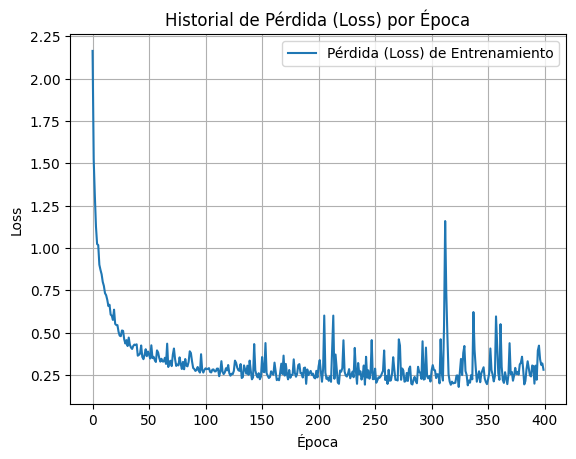


--- FASE 5: Probando modelo en cuda ---
Evaluando modelo contra el conjunto de prueba...


Evaluando: 100%|██████████| 230/230 [00:33<00:00,  6.81batch/s]



          RESULTADOS DE LA EVALUACIÓN (BIOMAS)
Accuracy (Exactitud): 0.8106 (81.06%)
Precision (Precisión - Macro): 0.7920 (79.20%)
Recall (Sensibilidad - Macro): 0.7805 (78.05%)

--- Reporte de Clasificación (Precisión, Recall, F1) ---
                        precision    recall  f1-score   support

              Badlands       0.98      0.98      0.98        64
          Bosque Mixto       0.47      0.27      0.35       459
       Bosque de Abeto       0.79      0.90      0.84       355
       Bosque de Roble       0.75      0.77      0.76       930
Bosque de Roble Oscuro       0.77      0.77      0.77       302
              Desierto       0.98      0.94      0.96       682
                Jungla       0.98      0.92      0.95       139
        Montaña Nevada       0.47      0.36      0.41       173
              Montañas       0.70      0.86      0.77       869
               Pantano       0.96      0.90      0.93       215
             Planicies       0.95      0.89      0.92    

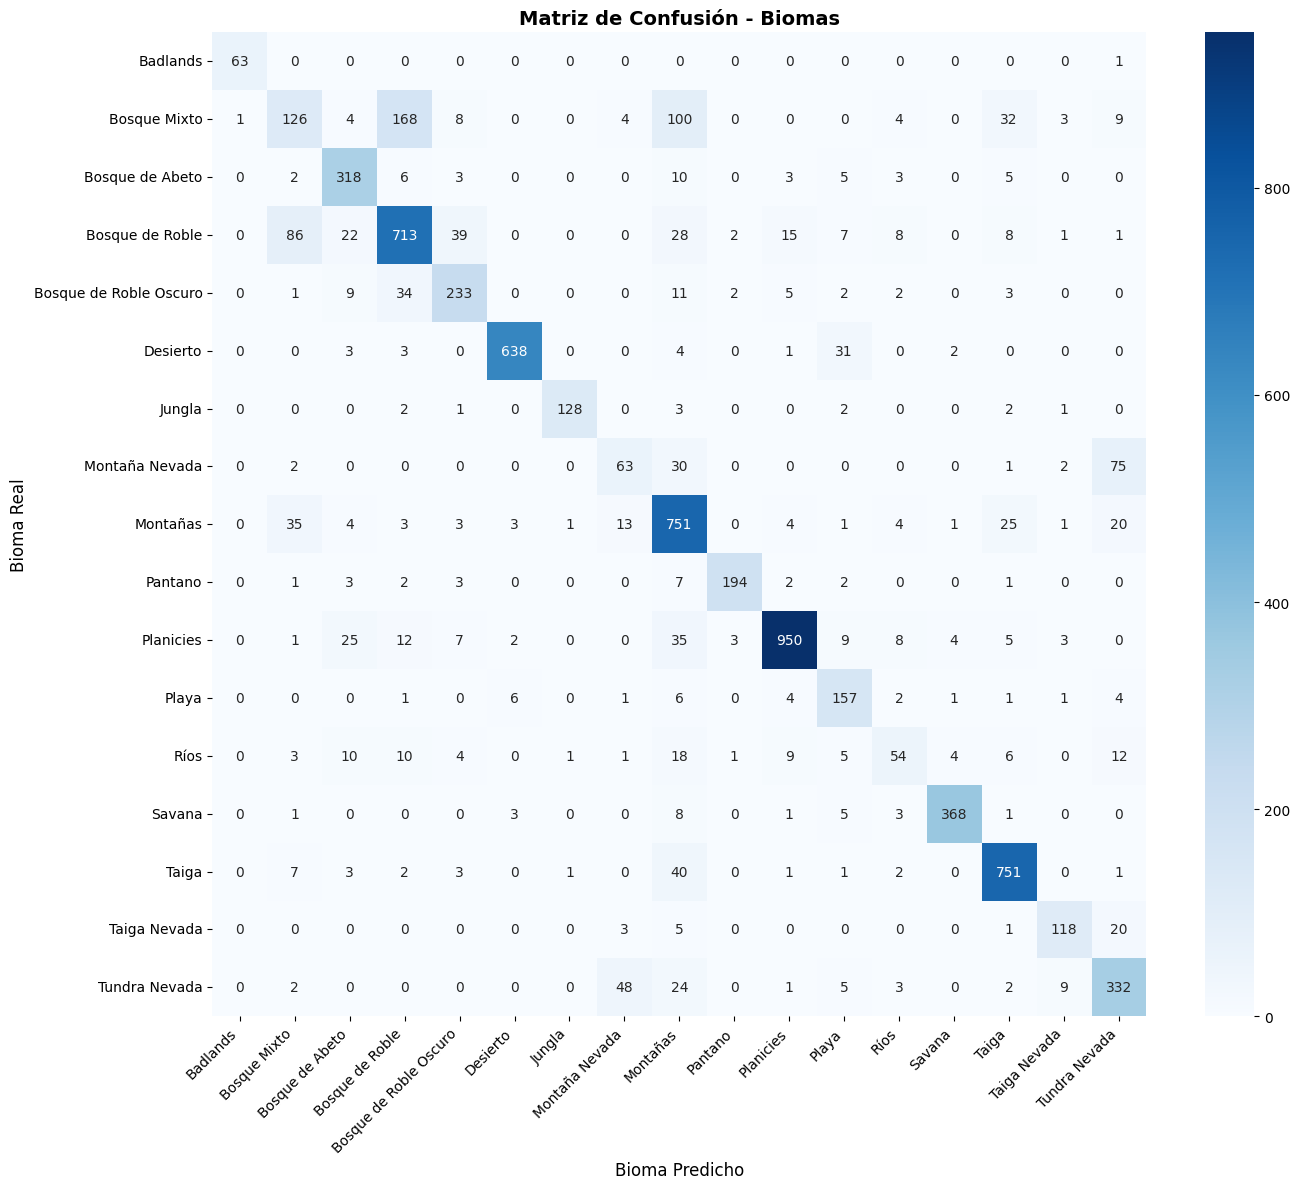

Gráfico de Matriz de Confusión generado.

--- FASE 6: Guardando modelo ---
Modelo guardado en /kaggle/working/auto_model_estandar_20251108_220348.pth

--- FLUJO AUTOMÁTICO COMPLETADO ---


In [9]:
if __name__ == "__main__":
    np.random.seed(SEMILLA_ALEATORIA)
    torch.manual_seed(SEMILLA_ALEATORIA)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEMILLA_ALEATORIA)

    tipo_ejecucion_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Unknown')

    if tipo_ejecucion_kaggle == 'Interactive':
        print("--- MODO INTERACTIVO (DRAFT) ---")
        print("Iniciando menú principal. Podrá usar 'input()'.\n")
        menu_principal()
    
    else:
        if tipo_ejecucion_kaggle == 'Batch':
            print("--- MODO NO INTERACTIVO (COMMIT / RUN ALL) ---")
        else:
            print(f"--- MODO NO INTERACTIVO (Fallback, KAGGLE_KERNEL_RUN_TYPE={tipo_ejecucion_kaggle}) ---")
        
        print("Iniciando flujo automático (sin inputs).\n")
        
        modelo_automatico = None
        params_arquitectura_auto = None
        historial_perdida_auto = []
        dispositivo_auto = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f" (Usando dispositivo: {dispositivo_auto})")

        try:
            print("\n--- FASE 1: Agrupando y verificando el dataset ---")
            if not preparar_y_agrupar_biomas():
                print("Error crítico en la agrupación del dataset. Abortando.")
                sys.exit(1)

            print("\n--- FASE 2: Cargando y preparando datasets (PyTorch) ---")
            datos_entrenamiento, pesos_muestras_tensor, cargador_validacion, nombres_clases, numero_de_clases = cargar_y_preparar_datos(DIRECTORIO_DATOS)
            if datos_entrenamiento is None:
                print("No se pudieron cargar los datos. Abortando.")
                sys.exit(1)

            print("\n--- FASE 3: Creación de Modelo (CNN) ---")
            tipo_arquitectura_auto = "estandar"
            print(f"Arquitectura seleccionada: {tipo_arquitectura_auto}")
            
            params_arquitectura_auto = {
                'num_classes': numero_de_clases,
                'architecture_type': tipo_arquitectura_auto
            }
            params_creacion_auto = {
                'numero_de_clases': params_arquitectura_auto['num_classes'],
                'tipo_arquitectura': params_arquitectura_auto['architecture_type']
            }
            
            modelo_automatico = ClasificadorBiomasCNN(**params_creacion_auto).to(dispositivo_auto)
            print("\n--- Nueva Red CNN Creada ---")

            epocas_auto = 400
            lr_auto = 0.001
            porcentaje_auto = 1.0
            print(f"\n--- FASE 4: Iniciando Entrenamiento ---")
            print(f"Épocas: {epocas_auto}, LR: {lr_auto}, Dataset: {porcentaje_auto*100:.0f}%")
            
            total_muestras = len(pesos_muestras_tensor)
            muestras_a_usar = int(total_muestras * porcentaje_auto)
            muestreador_auto = torch.utils.data.WeightedRandomSampler(
                weights=pesos_muestras_tensor,
                num_samples=muestras_a_usar,
                replacement=True
            )
            cargador_entrenamiento_auto = DataLoader(datos_entrenamiento,
                                                    batch_size=TAMANO_LOTE,
                                                    sampler=muestreador_auto,
                                                    num_workers=2,
                                                    pin_memory=True)
            
            nueva_perdida_auto = entrenar_modelo(modelo_automatico, cargador_entrenamiento_auto, epocas_auto, lr_auto, dispositivo_auto)
            historial_perdida_auto.extend(nueva_perdida_auto)
            
            print("Generando gráfico de pérdida...")
            graficar_historial_perdida(historial_perdida_auto)

            print(f"\n--- FASE 5: Probando modelo en {dispositivo_auto} ---")
            evaluar_modelo(modelo_automatico, cargador_validacion, dispositivo_auto, nombres_clases)

            print("\n--- FASE 6: Guardando modelo ---")
            marca_temporal = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            nombre_archivo_modelo = f"auto_model_estandar_{marca_temporal}.pth"
            guardar_red_neuronal(modelo_automatico, params_arquitectura_auto, nombre_archivo_modelo)
            
            print("\n--- FLUJO AUTOMÁTICO COMPLETADO ---")

        except Exception as e:
            print(f"Ocurrió un error en el flujo automático: {e}")
            import traceback
            traceback.print_exc()
            sys.exit(1)